# Narrow Scope Analysis

In [1]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import chain
from windrose import WindroseAxes

qpe = pd.read_csv('./data/QPE.csv')
qpe['datetime'] = pd.to_datetime(qpe['datetime'])

station_data = pd.read_csv('./data/Station_data.csv')
station_data['datetime'] = pd.to_datetime(station_data['datetime'])

## Sublimation cases extraction and plot

Here the same methodology as for the large scope will be applied to extract sublimation events.

1. **Set the criteria and filter the data:**

In [2]:
hours = 5
aqc_teshold = 0.05

mask = (qpe['aqc'] > aqc_teshold) & (qpe['precip'] == 0)
qpe_sublimation = qpe[mask]

time_diff = qpe['datetime'].diff()
mask_hourly = (time_diff == pd.Timedelta(hours=1)) | (mask & ~mask.shift(1).fillna(False))
mask_consecutive = mask & mask_hourly
consecutive_hours = mask_consecutive.rolling(window=hours).sum()
mask_at_least_three = consecutive_hours >= hours
mask_expanded = mask_at_least_three
for _ in range(hours-1):
    mask_expanded |= mask_expanded.shift(-1)
qpe_sublimation_consecutive = qpe[mask_expanded]

2. **Split the result into a list of individual events:**

In [3]:
def split_into_events(df):
    events = []
    current_event = []

    for i, row in df.iterrows():
        if not current_event:
            current_event.append(row)
        else:
            # Calculate the time difference between the current row and the last row of the current event
            time_diff = row['datetime'] - current_event[-1]['datetime']

            if time_diff == pd.Timedelta(hours=1):
                current_event.append(row)
            else:
                # When the time difference is not 1 hour, start a new event
                events.append(pd.DataFrame(current_event))
                current_event = [row]

    # Adding the last event if it's not empty
    if current_event:
        events.append(pd.DataFrame(current_event))

    return events


events = split_into_events(qpe_sublimation_consecutive)
number_of_events = len(events)
number_of_events 

26

3. **Represent the events visually:**

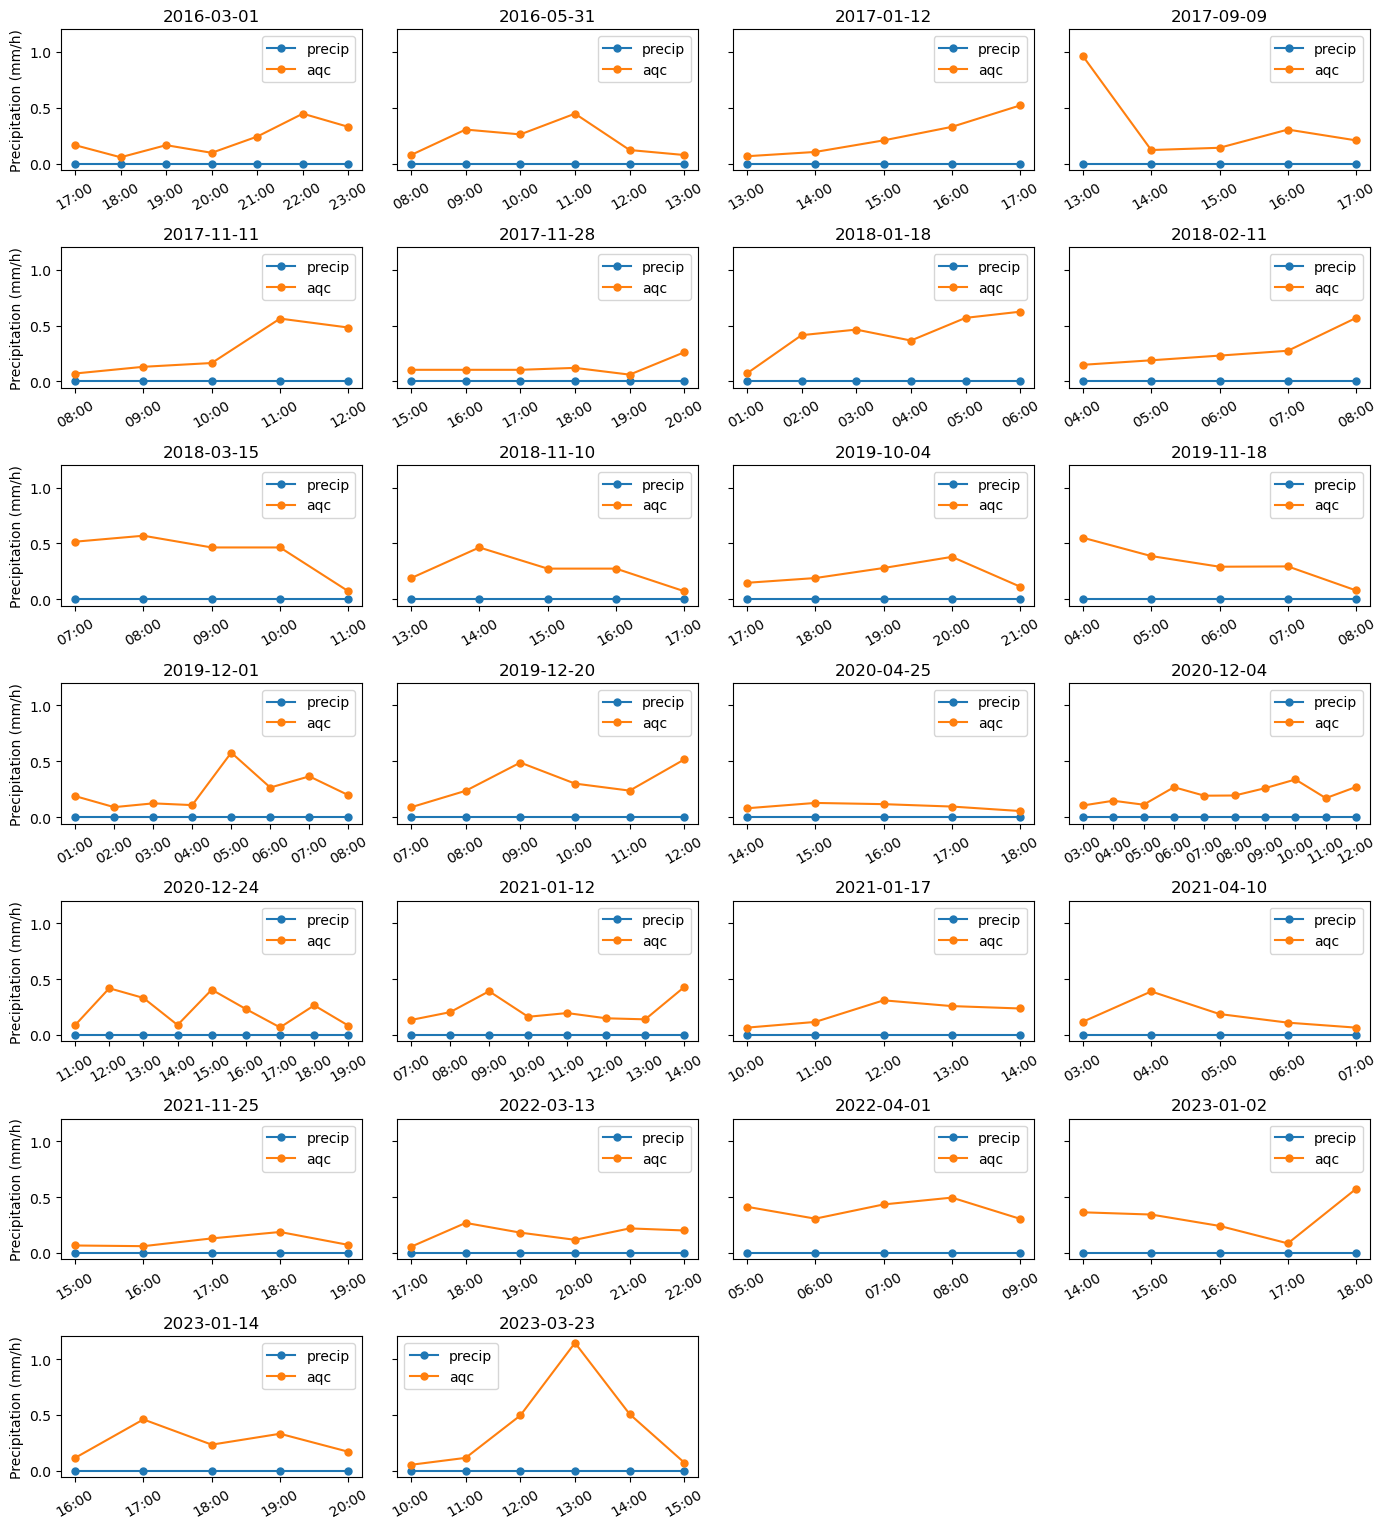

In [4]:
rows = math.ceil(number_of_events / 4)
fig, axs = plt.subplots(rows, 4, figsize=(14, 2.2*rows), sharey=True)

# Flatten the axes array for easier iteration
axs = axs.ravel()

for i, event in enumerate(events):
    axs[i].plot(event['datetime'], event['precip'], label='precip', marker='o', markersize=5)
    axs[i].plot(event['datetime'], event['aqc'], label='aqc', marker='o', markersize=5)

    # Extracting the date from the index and setting it as the title
    date = event['datetime'].iloc[0].strftime('%Y-%m-%d')
    axs[i].set_title(date)
    
    axs[i].legend()
    axs[i].xaxis.set_major_locator(mdates.HourLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate x-tick labels
    axs[i].tick_params(axis='x', rotation=30)
    
    # Add y-axis label only for the subplots on the left edge
    if i % 4 == 0:  # Check if the subplot is in the first column
        axs[i].set_ylabel('Precipitation (mm/h)')

# Hide any unused subplots if the number of events is not a multiple of 6
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/sublimation_events_narrow.pdf', dpi=300, bbox_inches='tight')

## Plot variable changes during events

In [5]:
def plot_variable_change_during_events(column, variable_name, save=False):
   
    number_of_events = len(events)
    rows = math.ceil(number_of_events / 4)
    
    fig, axs = plt.subplots(rows, 4, figsize=(16, 2.3*rows), sharey=True)
    axs = axs.flatten()  # Flatten the array for easy iteration

    # Define the DateFormatter to only show the hour
    hour_formatter = mdates.DateFormatter('%H:%M')

    # Loop over each event and plot
    for i, event_df in enumerate(events):
    
        # Get the start and end of the event
        start_event = event_df['datetime'].min()
        end_event = event_df['datetime'].max()
    
        # Calculate the start and end of the plot window (4 hours before and after)
        start_plot = start_event - pd.Timedelta(hours=4)
        end_plot = end_event + pd.Timedelta(hours=4)
    
        # Select the variable data for the plot window using boolean indexing
        plot_df = station_data[(station_data['datetime'] >= start_plot) & (station_data['datetime'] <= end_plot)]

        # Plot the variable data
        axs[i].plot(plot_df['datetime'], 
                plot_df[column], 
                marker='o', markersize=5)
    
        # Highlight the event duration
        axs[i].axvline(start_event, color='green', linestyle='--')
        axs[i].axvline(end_event, color='red', linestyle='--')
    
        # Set the title to the start date of the event
        axs[i].set_title(start_event.strftime('%Y-%m-%d'))
    
        # Format the x-axis to only show the hour
        axs[i].xaxis.set_major_formatter(hour_formatter)
    
        # Rotate the x-axis labels to prevent overlap
        plt.setp(axs[i].get_xticklabels(), rotation=30, ha='right')
    
        # Add y-axis label only for the subplots on the left edge
        if i % 4 == 0:  # Check if the subplot is in the first column
            axs[i].set_ylabel(variable_name)
    
    # Hide any unused subplots if the number of events is not a multiple of 6
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    if save==True:
        plt.savefig(f'./figures/{column}_change_during events.pdf', dpi=300, bbox_inches='tight')
    plt.show()

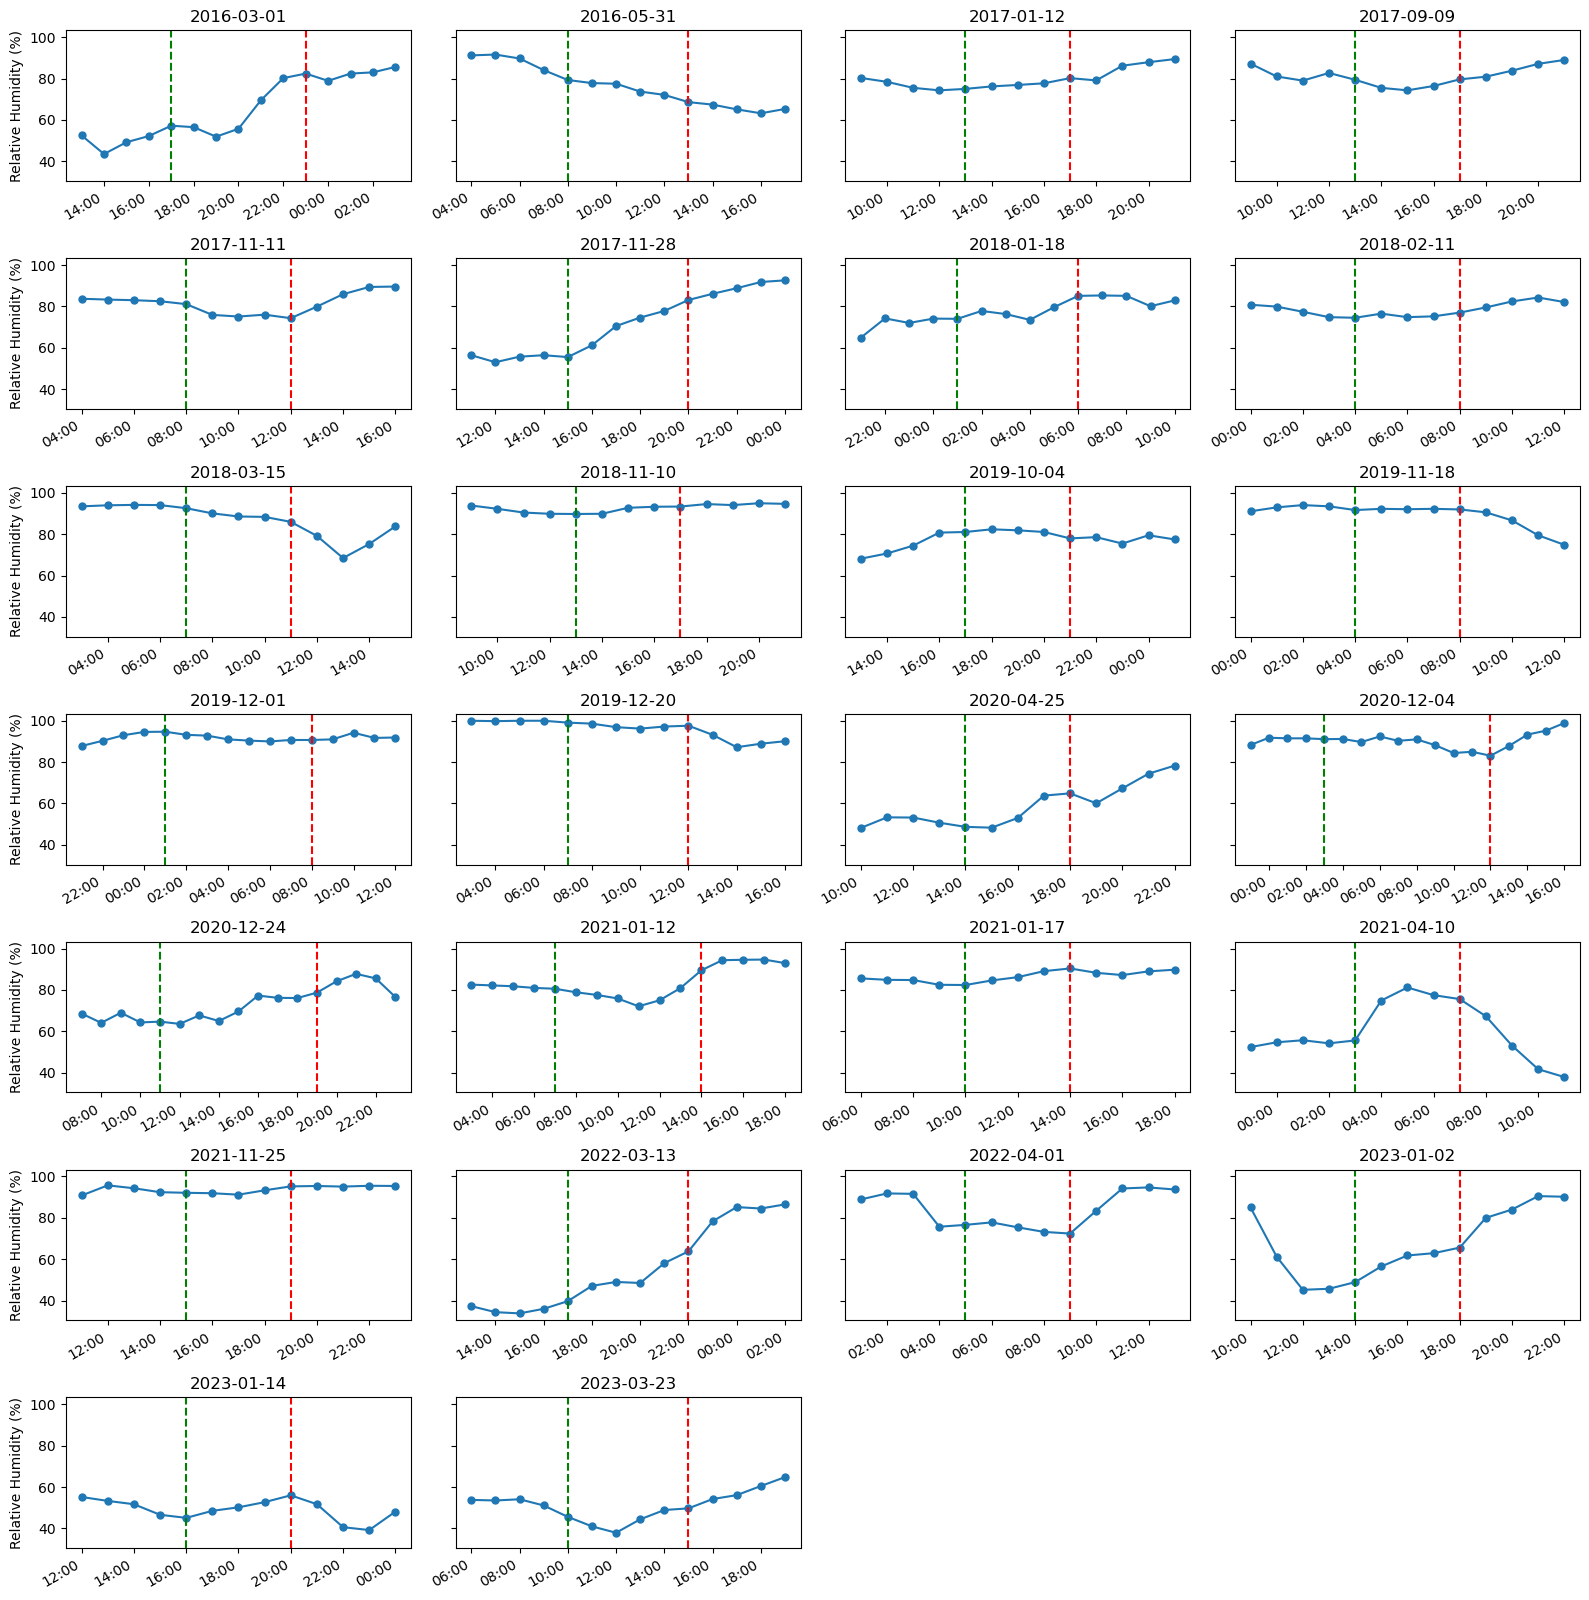

In [6]:
plot_variable_change_during_events('rh', 'Relative Humidity (%)', save=True)

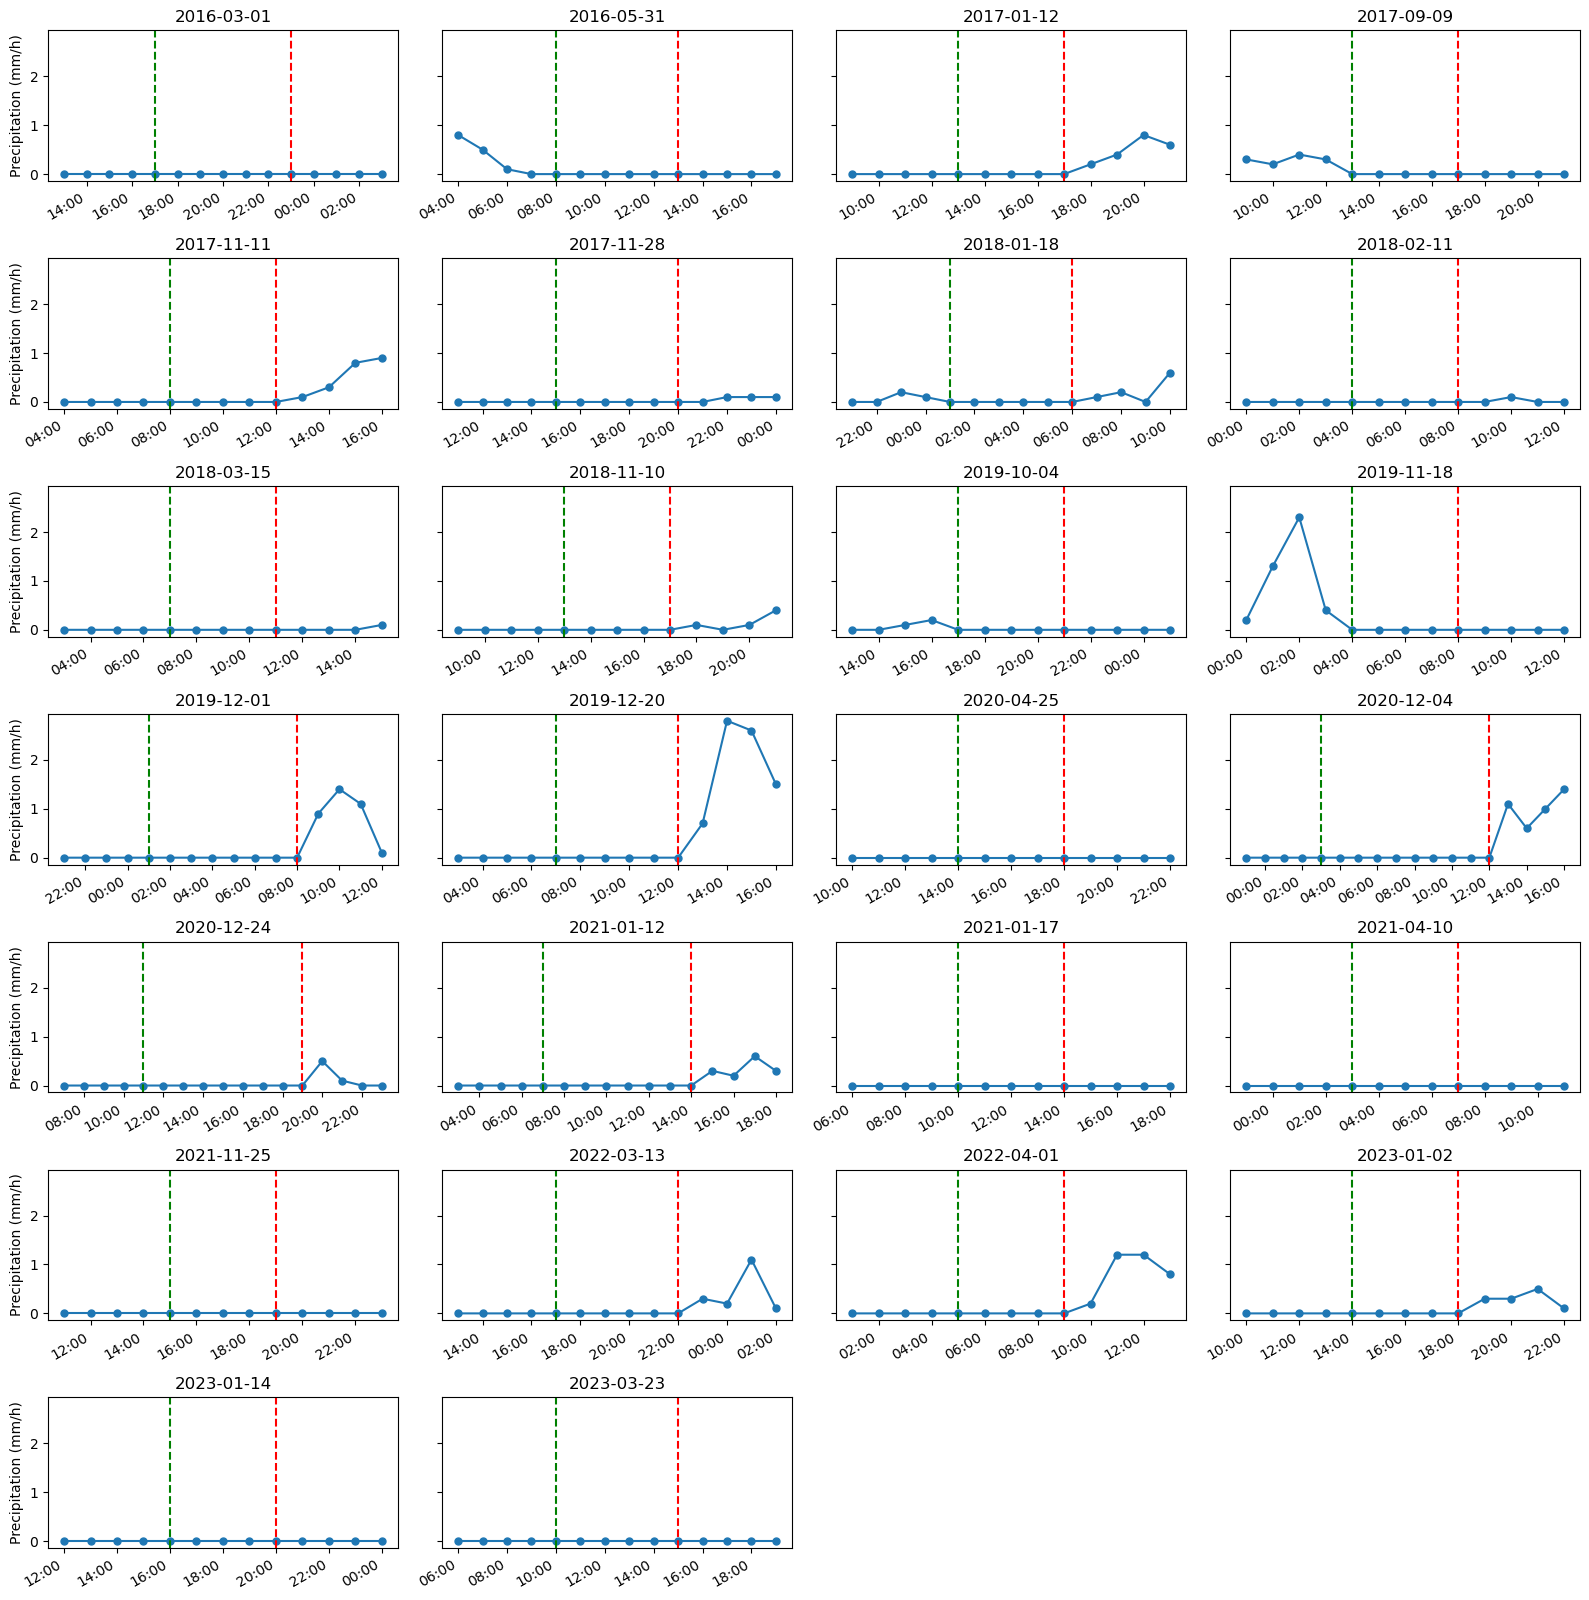

In [7]:
plot_variable_change_during_events('precip', 'Precipitation (mm/h)', save=True)

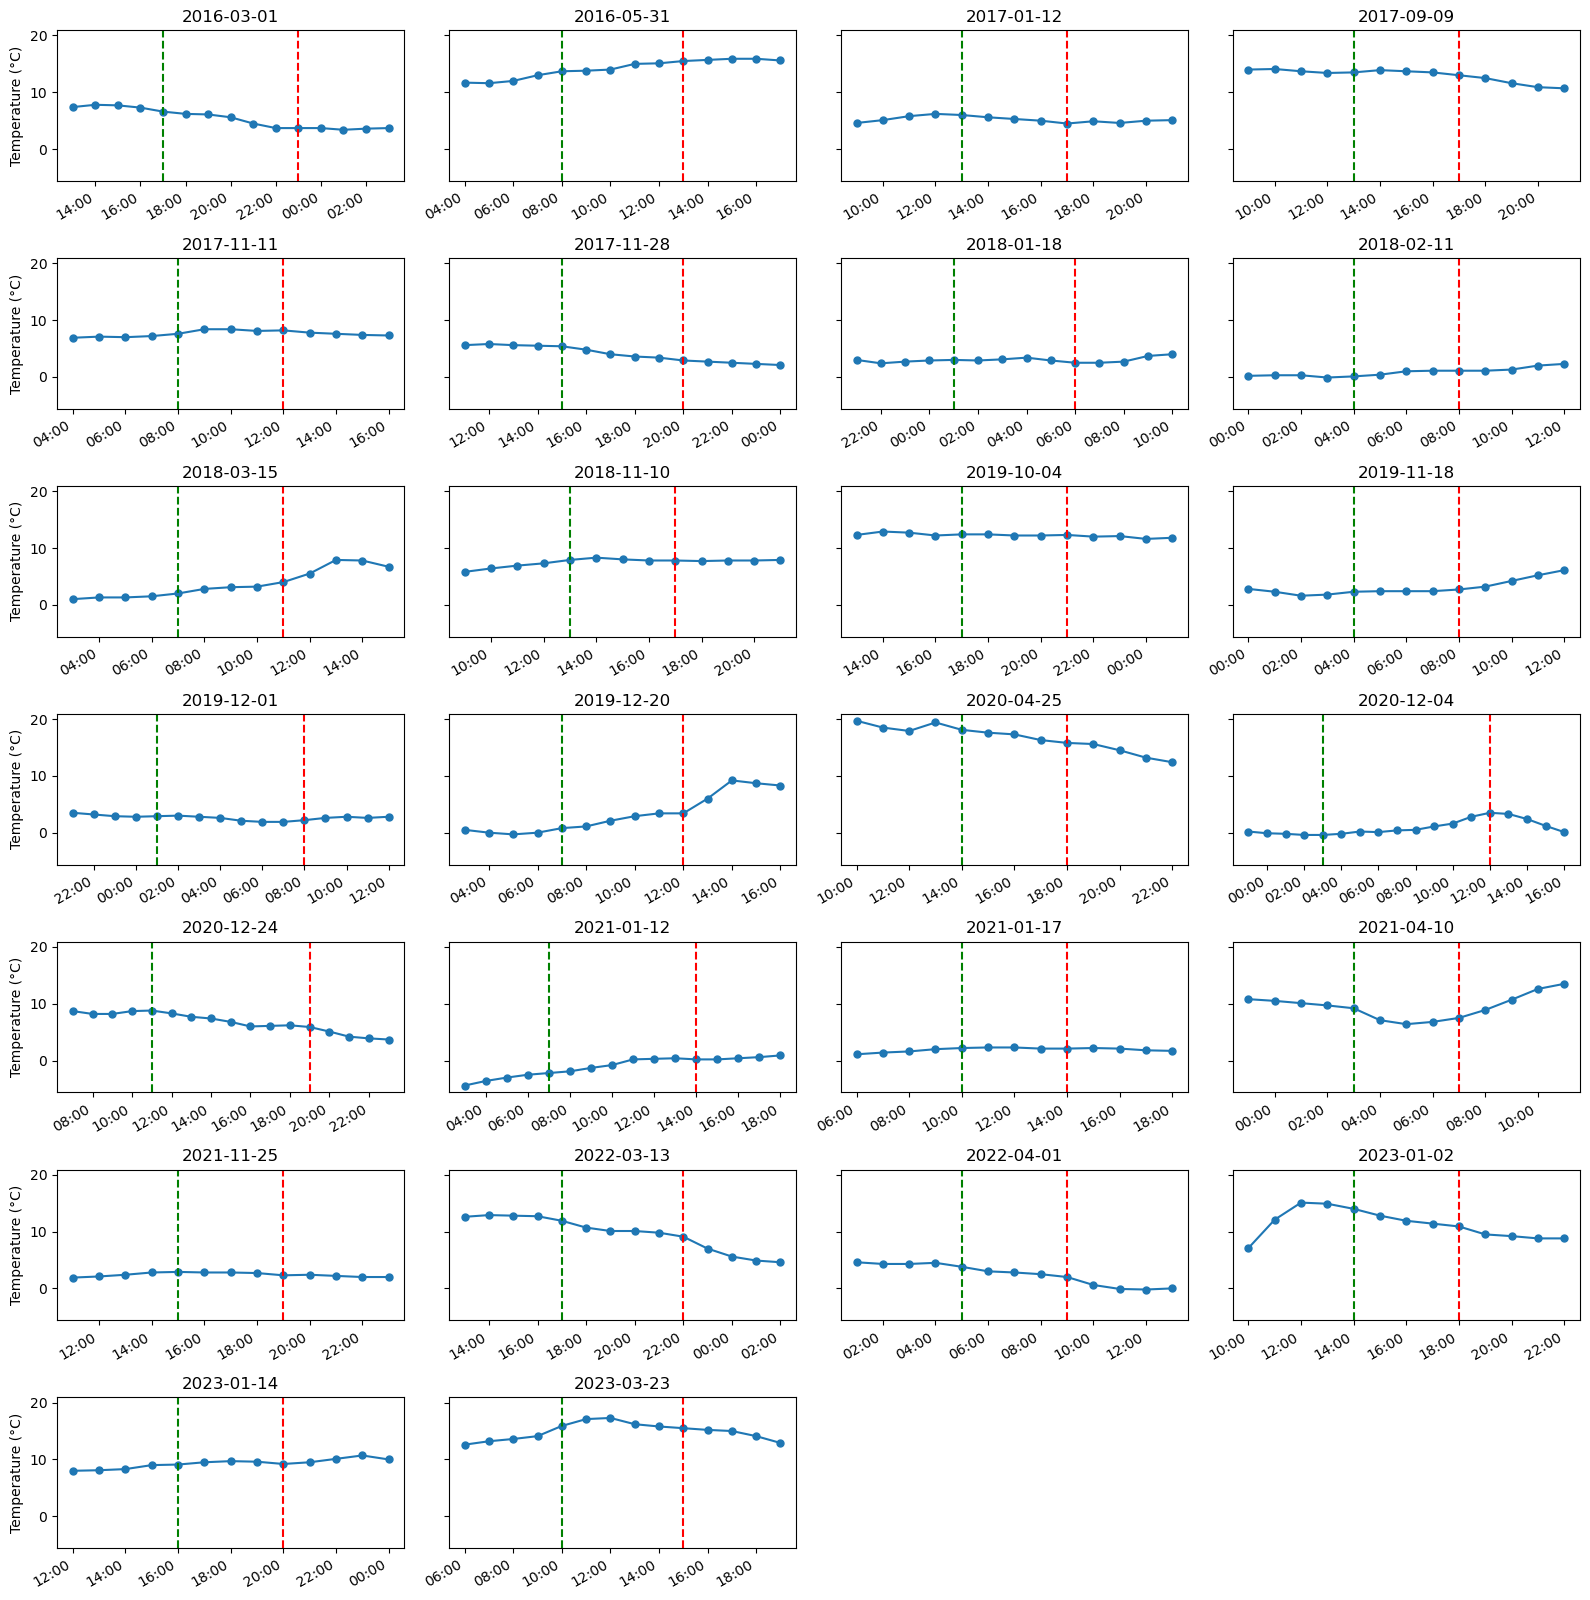

In [8]:
plot_variable_change_during_events('air_temp', 'Temperature (°C)', save=True)

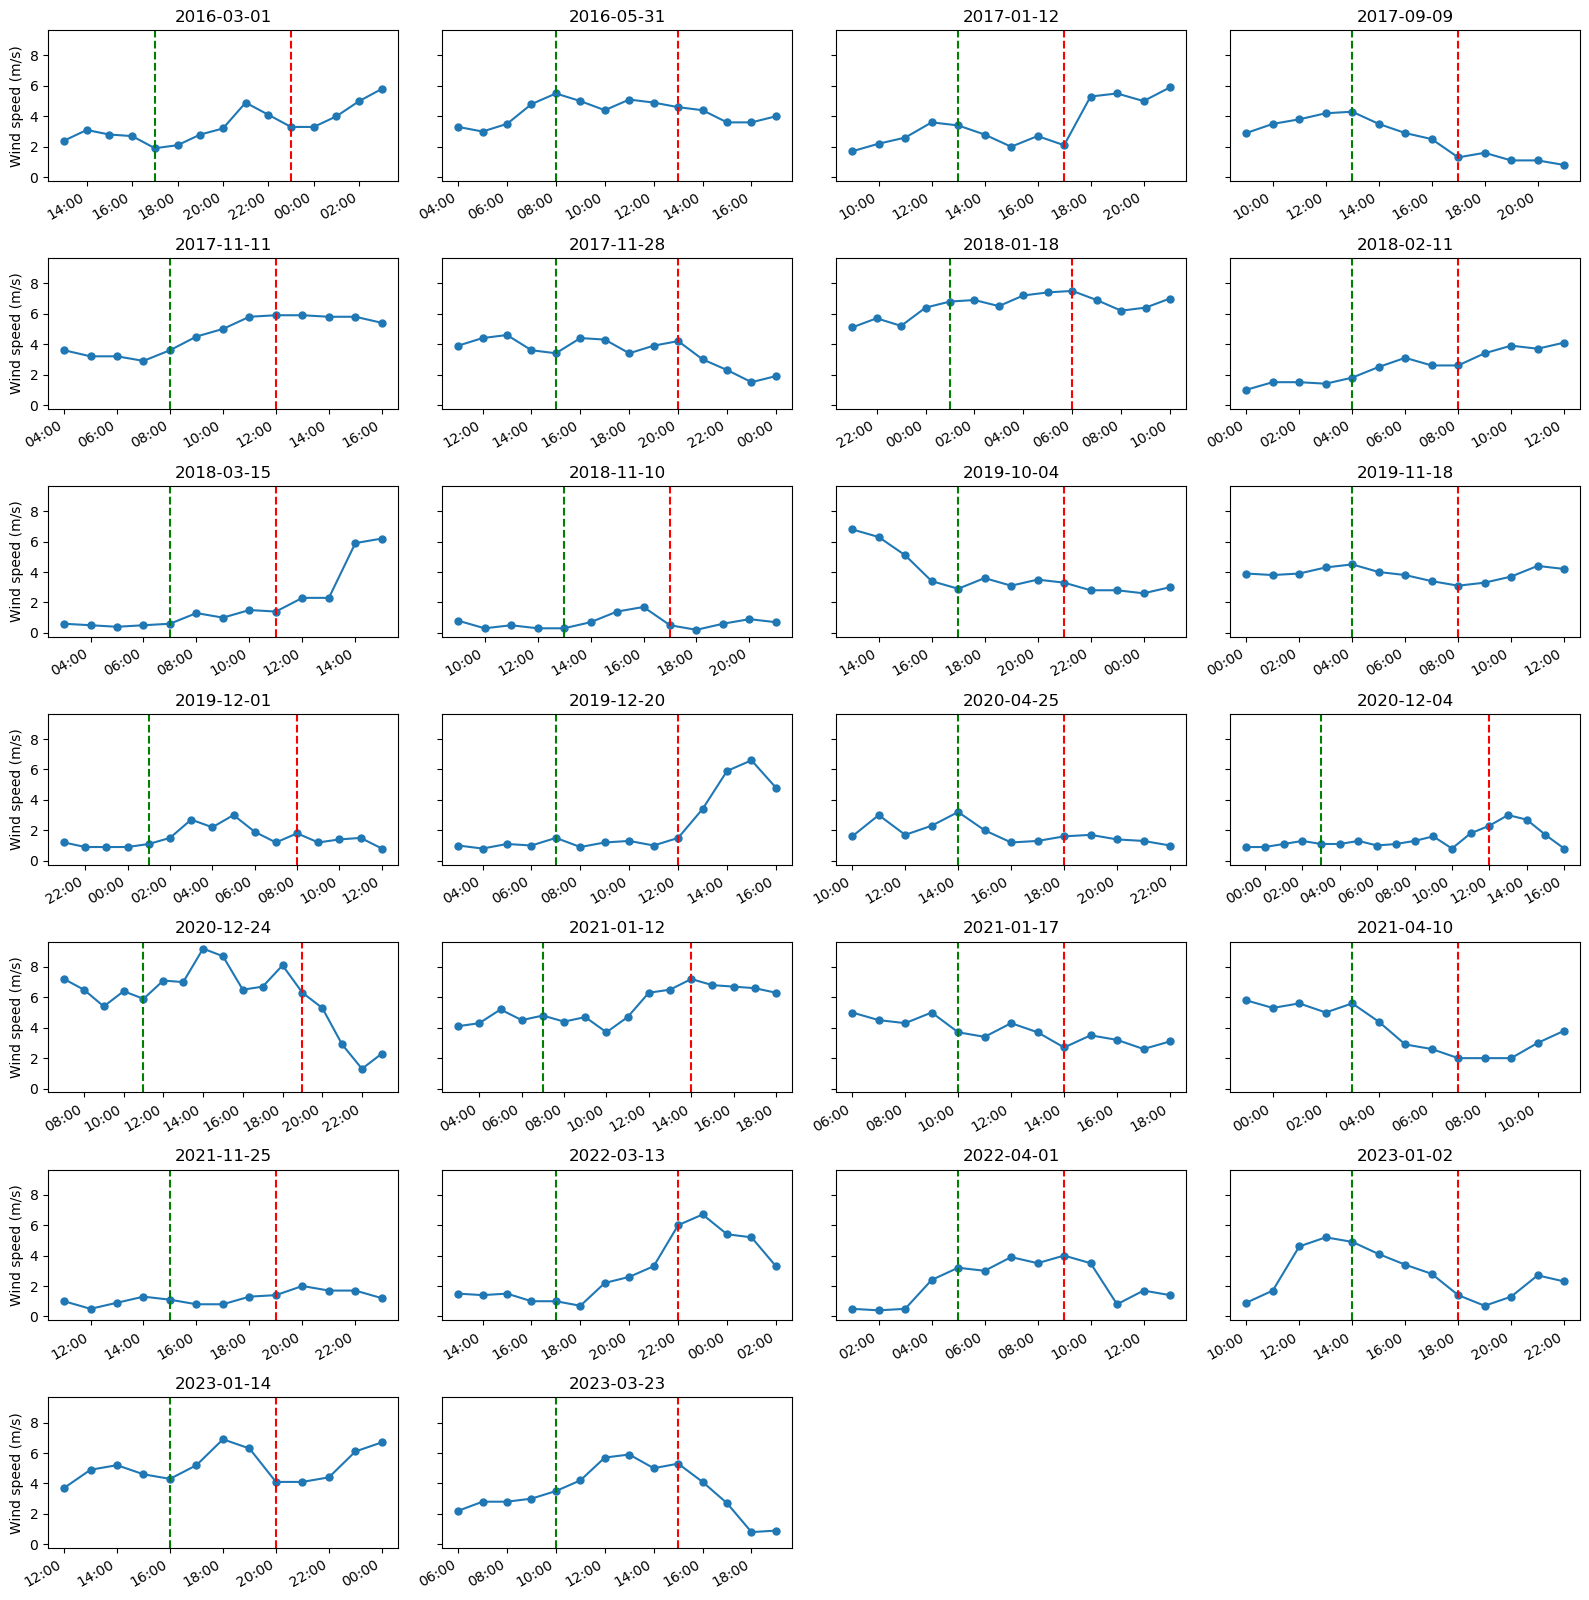

In [9]:
plot_variable_change_during_events('wind_speed', 'Wind speed (m/s)', save=True)

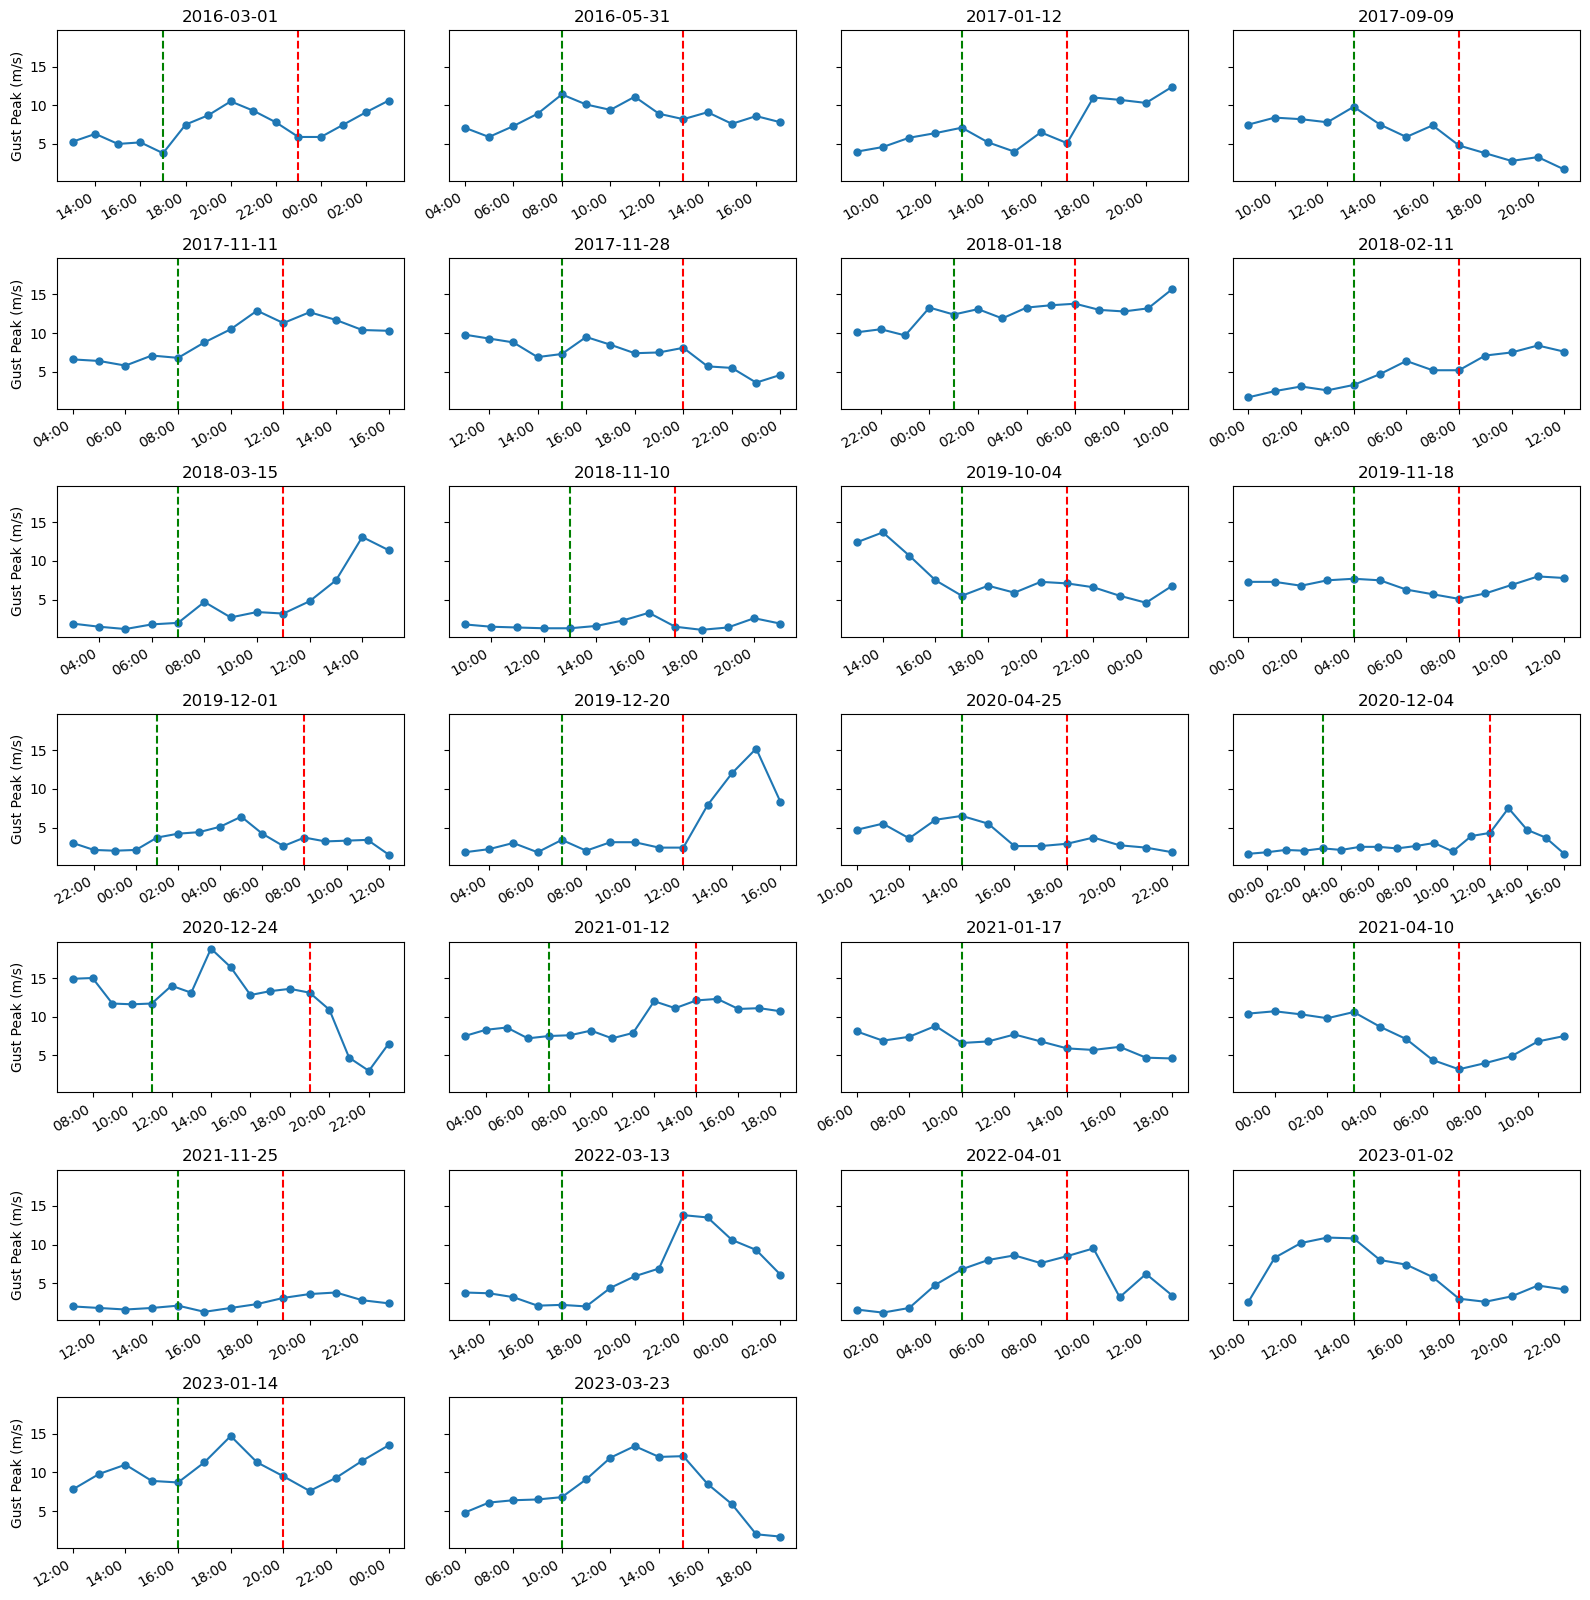

In [10]:
plot_variable_change_during_events('gust_peak', 'Gust Peak (m/s)', save=True)

## Pre-precipitation Events Analysis

To analyse the pre-precipitation events specifically, the classification methodology needs to be applied again (the same code is used)

1. **Event classification:**

In [11]:
for event_df in events:
    # Initialize the classification for each event
    classification = 'isolated'

    # Find the start and end times of the event
    event_start_time = event_df['datetime'].min()
    event_end_time = event_df['datetime'].max()

    # Define the time windows: two hours before the start and two hours after the end of the event
    two_hours_before_start = event_start_time - pd.Timedelta(hours=2)
    two_hours_after_end = event_end_time + pd.Timedelta(hours=2)

    # Extract relevant precipitation data from 'qpe'
    before_event_precip = qpe[(qpe['datetime'] >= two_hours_before_start) & (qpe['datetime'] < event_start_time)]
    after_event_precip = qpe[(qpe['datetime'] > event_end_time) & (qpe['datetime'] <= two_hours_after_end)]

    # Classification logic
    if before_event_precip['precip'].sum() > 0 and after_event_precip['precip'].sum() > 0:
        classification = 'within-precipitation'
    elif before_event_precip['precip'].sum() > 0:
        classification = 'post-precipitation'
    elif after_event_precip['precip'].sum() > 0:
        classification = 'pre-precipitation'

    # Add classification to the event DataFrame
    event_df['classification'] = classification

2. **Plot pre-precipitation events and relative humidity:**

The relative humidity change during each event will be saved into a dictionnary for later use.

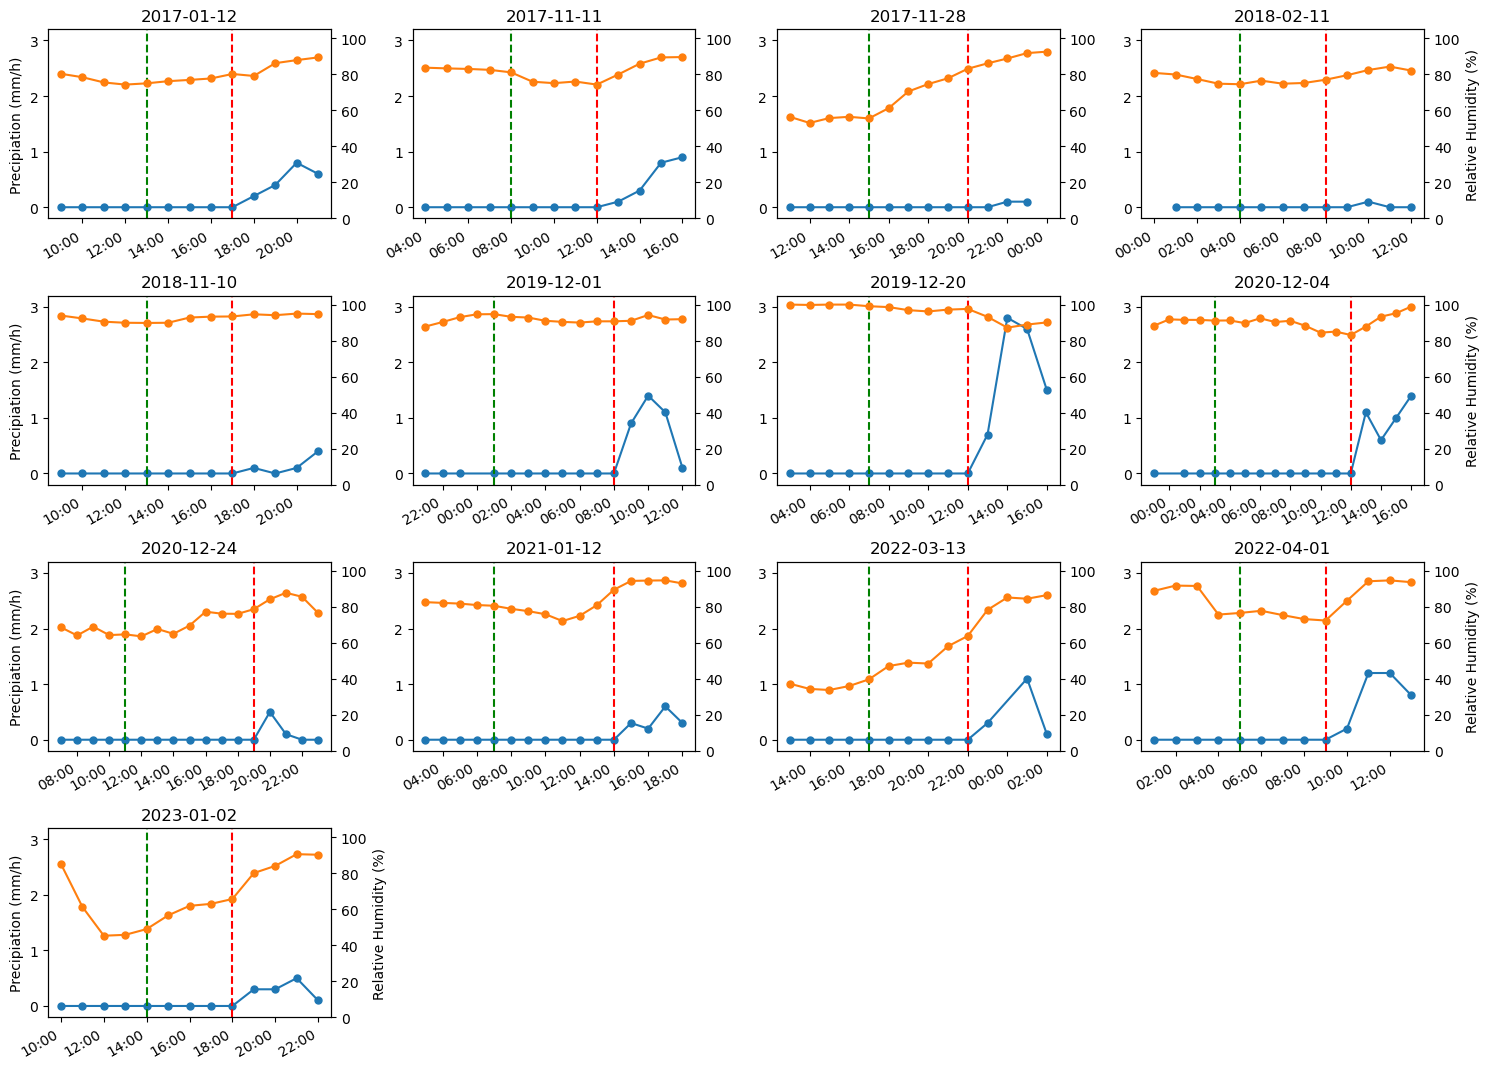

In [12]:
# Filter only the 'pre-precipitation' events
pre_precip_events = [event for event in events if event['classification'].iloc[0] == 'pre-precipitation']
number_of_events = len(pre_precip_events)

# Set up the subplot grid
rows = math.ceil(number_of_events / 4)
fig, axs = plt.subplots(rows, 4, figsize=(15, 2.7*rows))
axs = axs.flatten()  # Flatten the array for easy iteration

# Define the DateFormatter to only show the hour
hour_formatter = mdates.DateFormatter('%H:%M')

# Initialize a dictionary to store RH differences
rh_differences = {}

# Loop over each pre-precipitation event and plot
for i, event_df in enumerate(pre_precip_events):
    # Get the start and end of the event
    start_event = event_df['datetime'].min()
    end_event = event_df['datetime'].max()
    
    # Calculate the start and end of the plot window (4 hours before and after)
    start_plot = start_event - pd.Timedelta(hours=4)
    end_plot = end_event + pd.Timedelta(hours=4)
    
    # Select the precipitation and humidity data for the plot window using boolean indexing
    precip_during_event = qpe[(qpe['datetime'] >= start_plot) & (qpe['datetime'] <= end_plot)]
    rh_during_event = station_data[(station_data['datetime'] >= start_plot) & (station_data['datetime'] <= end_plot)]

    # Plot the precipitation data
    ax_precip = axs[i]
    ax_precip.plot(precip_during_event['datetime'], precip_during_event['precip'], 
                   marker='o', markersize=5, label='Precipitation (mm/h)')

    # Create a twin y-axis for relative humidity
    ax_rh = ax_precip.twinx()
    ax_rh.plot(rh_during_event['datetime'], rh_during_event['rh'], 
               marker='o', markersize=5, color='#ff7f0e', label='Relative Humidity (%)')

    # Highlight the event duration
    ax_precip.axvline(start_event, color='green', linestyle='--')
    ax_precip.axvline(end_event, color='red', linestyle='--')
    
    # Set the title to the start date of the event
    ax_precip.set_title(start_event.strftime('%Y-%m-%d'))
    
    # Format the x-axis to only show the hour
    ax_precip.xaxis.set_major_formatter(hour_formatter)
    
    # Rotate the x-axis labels to prevent overlap
    plt.setp(ax_precip.get_xticklabels(), rotation=30, ha='right')
        
    # Set the y-axis limits
    ax_rh.set_ylim(0, 105)
    ax_precip.set_ylim(-0.2, 3.2)

    # Only set y-labels for the far left and far right plots
    if i % 4 == 0:  # First plot in each row
        ax_precip.set_ylabel('Precipiation (mm/h)')
    if i % 4 == 3 or i == len(pre_precip_events) - 1:  # Last plot in each row or last plot overall
        ax_rh.set_ylabel('Relative Humidity (%)')
    
    # Calculate the RH difference
    start_rh = rh_during_event[rh_during_event['datetime'] == start_event]['rh'].iloc[0]
    end_rh = rh_during_event[rh_during_event['datetime'] == end_event]['rh'].iloc[0]
    rh_difference = end_rh - start_rh

    # Store the difference in the dictionary
    rh_differences[start_event.strftime('%Y-%m-%d')] = rh_difference

# Convert the dictionary to a DataFrame for easier analysis or export
rh_differences_df = pd.DataFrame(list(rh_differences.items()), columns=['Date', 'RH Difference (%)'])

# Hide any unused subplots if the number of events is not a multiple of 4
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/pre_precip.pdf', dpi=300, bbox_inches='tight')
plt.show()

3. **Relative humidity difference during each event:**

In [13]:
rh_differences_df

,Date,RH Difference (%)
0,2017-01-12,5.2
1,2017-11-11,-6.8
2,2017-11-28,27.6
3,2018-02-11,2.5
4,2018-11-10,3.6
5,2019-12-01,-4.0
6,2019-12-20,-1.5
7,2020-12-04,-8.0
8,2020-12-24,14.0
9,2021-01-12,8.9


In [14]:
print(rh_differences_df['RH Difference (%)'].mean())

6.007692307692309


## Wind Analysis

### Wind Speeds

1. **Extracts the wind speeds, average wind speed, wind directions and average gust peak for each event:**

In [15]:
def get_wind_speed_direction_and_gust_peak(event_df, station_data):
    # Merging the event dataframe with station_data on datetime
    merged_df = pd.merge(event_df, station_data, on='datetime', how='left')
    
    # Calculating the average wind speed for each event datetime
    avg_wind_speed = merged_df['wind_speed'].mean()

    # Getting a list of all wind directions for the event
    wind_directions = merged_df['wind_direction'].dropna().tolist()

    # Calculating the average gust peak for each event datetime
    avg_gust_peak = merged_df['gust_peak'].mean()

    # Getting a list of all wind speeds for the event
    wind_speeds = merged_df['wind_speed'].dropna().tolist()
    
    return wind_speeds, avg_wind_speed, wind_directions, avg_gust_peak

# List to store the average wind speeds, wind directions, average gust peaks, and wind speeds for each event dataframe
event_wind_details_list = []

# Iterating through each dataframe in the 'events' list
for event_df in events:
    wind_speeds, avg_wind_speed, wind_directions, avg_gust_peak  = get_wind_speed_direction_and_gust_peak(event_df, station_data)
    event_wind_details_list.append((wind_speeds, avg_wind_speed, wind_directions, avg_gust_peak,))
    
# Convert the list of tuples into a DataFrame
event_wind_details_df = pd.DataFrame(event_wind_details_list, 
                                     columns=['Wind Speeds',
                                              'Average Wind Speed',
                                              'Wind Directions', 
                                              'Average Gust Peak'])

event_wind_details_df

,Wind Speeds,Average Wind Speed,Wind Directions,Average Gust Peak
0,"[1.9, 2.1, 2.8, 3.2, 4.9, 4.1, 3.3]",3.185714,"[238.0, 237.0, 232.0, 237.0, 241.0, 236.0, 243.0]",7.642857
1,"[5.5, 5.0, 4.4, 5.1, 4.9, 4.6]",4.916667,"[217.0, 222.0, 217.0, 222.0, 219.0, 220.0]",9.850000
2,"[3.4, 2.8, 2.0, 2.7, 2.1]",2.600000,"[219.0, 212.0, 223.0, 227.0, 219.0]",5.580000
3,"[4.3, 3.5, 2.9, 2.5, 1.3]",2.900000,"[226.0, 229.0, 228.0, 228.0, 231.0]",7.080000
4,"[3.6, 4.5, 5.0, 5.8, 5.9]",4.960000,"[216.0, 219.0, 228.0, 234.0, 231.0]",10.060000
5,"[3.4, 4.4, 4.3, 3.4, 3.9, 4.2]",3.933333,"[227.0, 239.0, 246.0, 231.0, 220.0, 213.0]",8.050000
6,"[6.8, 6.9, 6.5, 7.2, 7.4, 7.5]",7.050000,"[217.0, 218.0, 221.0, 222.0, 221.0, 220.0]",13.016667
7,"[1.8, 2.5, 3.1, 2.6, 2.6]",2.520000,"[214.0, 227.0, 234.0, 230.0, 239.0]",4.960000
8,"[0.6, 1.3, 1.0, 1.5, 1.4]",1.160000,"[225.0, 60.0, 279.0, 18.0, 49.0]",3.200000
9,"[0.3, 0.7, 1.4, 1.7, 0.5]",0.920000,"[135.0, 39.0, 36.0, 16.0, 360.0]",2.000000


2. **Comparative histograms of all wind speeds and wind speeds during virga on linear and logarithmic scales (excluding zero values):**

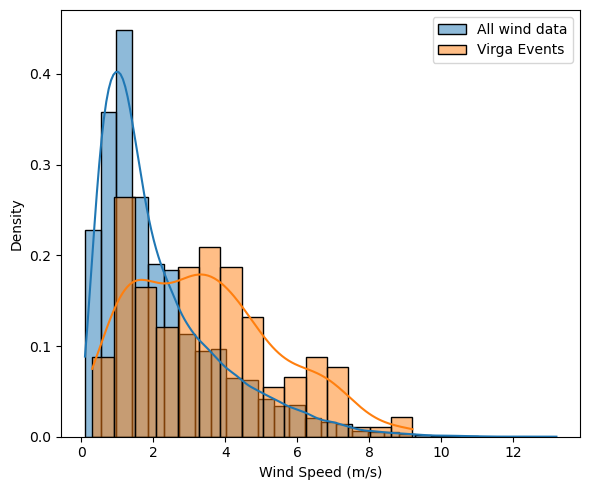

In [16]:
station_data_filtered = station_data[station_data['wind_speed'] > 0]
flattened_wind_speeds_filtered = [speed for sublist in event_wind_details_df['Wind Speeds'] for speed in sublist if speed > 0]

# Creating the figure for linear scale histograms
plt.figure(figsize=(6, 5))

# Plotting histogram for all wind data
sns.histplot(station_data_filtered['wind_speed'], bins=30, kde=True, stat="density",
             linewidth=1, color='C0', edgecolor='black', label='All wind data')

# Plotting histogram for wind speeds during events
sns.histplot(flattened_wind_speeds_filtered, bins=15, kde=True, stat="density",
             linewidth=1, color='C1', edgecolor='black', label='Virga Events')

plt.xlabel('Wind Speed (m/s)')
plt.legend()  
plt.tight_layout()
plt.savefig('./figures/Hist_wind_linear.pdf', dpi=300, bbox_inches='tight')
plt.show()

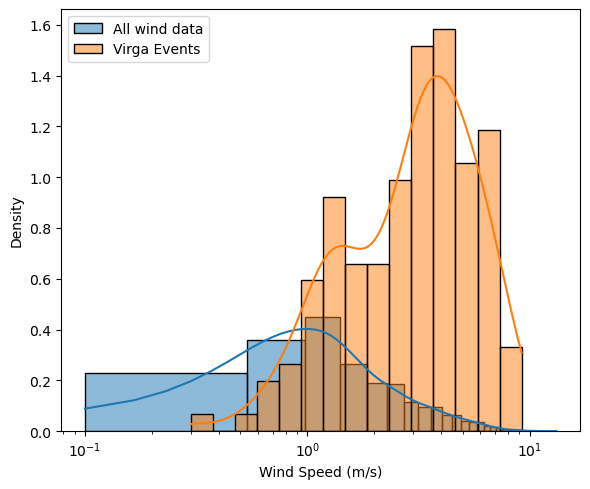

In [17]:
plt.figure(figsize=(6, 5))

# Plotting histogram for all wind data with log scale
sns.histplot(station_data_filtered['wind_speed'], bins=30, kde=True, stat="density",
             linewidth=1, color='C0', edgecolor='black', label='All wind data')
plt.xscale('log')

# Plotting histogram for wind speeds during events with log scale
sns.histplot(flattened_wind_speeds_filtered, bins=15, kde=True, stat="density",
             linewidth=1, color='C1', edgecolor='black', label='Virga Events')
plt.xscale('log')

plt.xlabel('Wind Speed (m/s)')
plt.legend()  
plt.tight_layout()
plt.savefig('./figures/Hist_wind_log.pdf', dpi=300, bbox_inches='tight')
plt.show()

3. **Another way to compare both wind distributions:**

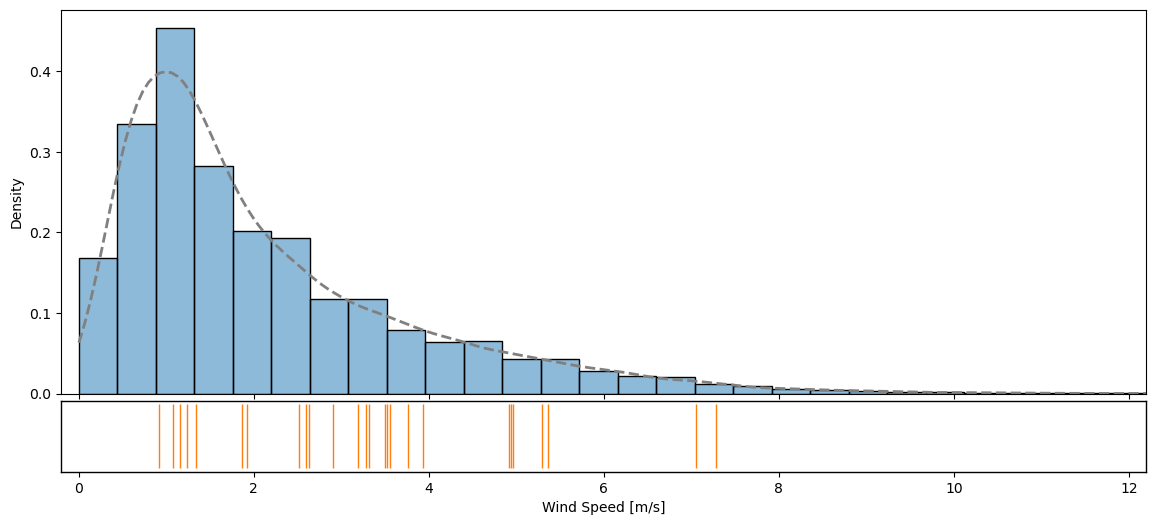

In [18]:
# Set up the main figure and axes
fig = plt.figure(figsize=(14, 6))
# Create a subplot grid with 2 rows, 1 column
# ax_main will occupy the first 5 parts of the grid, ax_inset the last one
ax_main = plt.subplot2grid((6, 1), (0, 0), rowspan=5, fig=fig)
ax_inset = plt.subplot2grid((6, 1), (5, 0), rowspan=1, fig=fig, sharex=ax_main)

# Plot the main histogram
sns.histplot(station_data['wind_speed'], bins=30, kde=True, stat="density",
             linewidth=1, color='C0', edgecolor='black', ax=ax_main)
ax_main.set_ylabel('Density')
ax_main.set_xlim(-0.2,12.2)

# Customize KDE line style
plt.setp(ax_main.lines, color='grey', linestyle='--', linewidth=2)

# Remove x-axis label from the main plot
ax_main.set_xlabel('')

# Plot red vertical lines on the inset plot
average_wind_speeds = event_wind_details_df['Average Wind Speed']
ax_inset.vlines(average_wind_speeds, ymin=0, ymax=1, color='C1', linewidth=1)

# Format the inset plot to be narrower and have a border
ax_inset.set_yticks([])  # no y-ticks
ax_inset.spines['top'].set_linewidth(1)
ax_inset.spines['right'].set_linewidth(1)
ax_inset.spines['left'].set_linewidth(1)
ax_inset.spines['bottom'].set_linewidth(1)  # Visible spines (border)

# Set x-axis label for the inset plot
ax_inset.set_xlabel('Wind Speed [m/s]')

# Show x-axis labels and ticks on the inset plot only
fig.subplots_adjust(hspace=0.1)  # Adjust horizontal space to prevent overlap
ax_inset.xaxis.tick_bottom()

# Save the plot
plt.savefig('./figures/Histogram_Wind_speed.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Wind Direction

Here the wind direction will be represented using wind roses.

1. **All wind data:**

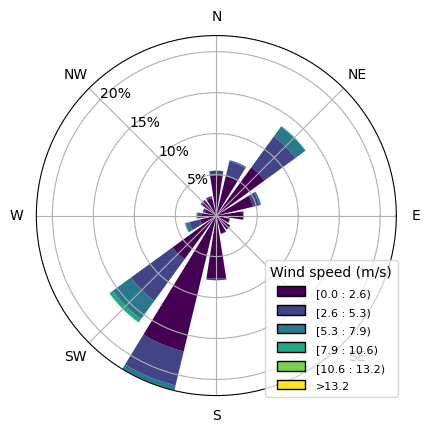

In [19]:
wind_speeds = station_data['wind_speed']
wind_directions = station_data['wind_direction']

# Create a windrose axes
ax = WindroseAxes.from_ax(fig=plt.figure(figsize=(4.5, 4.5)))  # Adjust the size as needed

# Plot the windrose with normed occurrence and without edgecolor for a cleaner look
ax.bar(wind_directions, wind_speeds, normed=True, opening=0.8, edgecolor=None)

# Set the legend and its title, remove bbox_to_anchor if you want the legend inside the plot
ax.set_legend(title="Wind speed (m/s)", loc='lower right')

# Customize the labels for the directions
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])

# Set the radius labels (frequency) to be more informative
# Angle at which the radial labels are displayed
ax.radii_angle = 45
# Set the grid labels (percentages can be calculated based on your data)
ax.set_rgrids([5, 10, 15, 20], labels=["5%", "10%", "15%", "20%"], angle=135)

plt.savefig('./figures/windrose_overall.pdf', dpi=300, bbox_inches='tight')
plt.show()

2. **Wind Direction when AQC > 0.05 mm/h:**

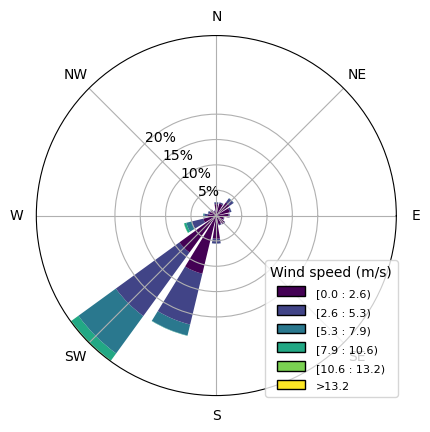

In [20]:
# Step 1: Filter 'qpe' DataFrame for AQC values > 0.05
qpe_filtered = qpe[qpe['aqc'] > 0.05]

# Step 2: Join with 'station_data' on 'datetime'
filtered_station_data = pd.merge(station_data, qpe_filtered, on='datetime', how='inner')

# Step 3: Extract wind speeds and directions from the filtered data
wind_speeds = filtered_station_data['wind_speed']
wind_directions = filtered_station_data['wind_direction']

# Step 4: Create and plot the windrose
ax = WindroseAxes.from_ax(fig=plt.figure(figsize=(4.5, 4.5)))  # Adjust the size as needed
ax.bar(wind_directions, wind_speeds, normed=True, opening=0.8, edgecolor=None)

# Set legend, labels, and customize plot
ax.set_legend(title="Wind speed (m/s)", loc='lower right')
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])
ax.radii_angle = 45
ax.set_rgrids([5, 10, 15, 20], labels=["5%", "10%", "15%", "20%"], angle=135)

plt.savefig('./figures/windrose_filtered.pdf', dpi=300, bbox_inches='tight')
plt.show()

3. **Wind Direction during virga events:**

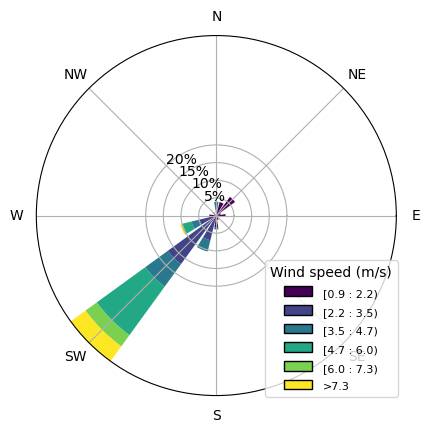

In [21]:
# Flatten the list of lists into a single list
wind_directions = list(chain.from_iterable(event_wind_details_df['Wind Directions']))

# Assuming wind_speeds is defined as before, with one average wind speed per list of directions
# We need to repeat each wind speed for the number of directions in each corresponding list
wind_speeds = []
for avg_speed, directions in zip(event_wind_details_df['Average Wind Speed'], event_wind_details_df['Wind Directions']):
    wind_speeds.extend([avg_speed] * len(directions))

# Create a windrose axes
ax = WindroseAxes.from_ax(fig=plt.figure(figsize=(4.5, 4.5)))

# Plot the windrose
ax.bar(wind_directions, wind_speeds, normed=True, opening=0.8, edgecolor=None)

# Set the legend
ax.set_legend(title="Wind speed (m/s)", loc='lower right')

# Customize the labels for the directions
ax.set_xticklabels(['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE'])

# Set the radii grid labels with the angle to avoid overlapping
# Adjust the 'angle' parameter to place labels where they don't overlap with other elements
ax.set_rgrids(radii=[5, 10, 15, 20], labels=["5%", "10%", "15%", "20%"], angle=135)  # Try different angles like 90, 135, etc.

plt.savefig('./figures/windrose_events.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Vertical Profile Descriptors

## Extract vertical profiles descriptors

1. **Selects the events of interest:**

In [22]:
events_with_soundings = [events[1], events[4], events[13], events[15], events[16], events[17], events[18], events[25]]

events_with_soundings_datetimes = []

for event in events_with_soundings:
    formatted_date = event['datetime'].iloc[0].strftime('%Y%m%d')
    events_with_soundings_datetimes.append(formatted_date)

In [23]:
events_with_soundings_datetimes

['20160531',
 '20171111',
 '20191220',
 '20201204',
 '20201224',
 '20210112',
 '20210117',
 '20230323']

2. **Load vertical profiles:**

In [24]:
# Dictionary to map dates to their respective directory paths
date_to_path = {
    events_with_soundings_datetimes[0]: "2016-05-31",
    events_with_soundings_datetimes[1]: "2017-11-11",
    events_with_soundings_datetimes[2]: "2019",
    events_with_soundings_datetimes[3]: "2020",
    events_with_soundings_datetimes[4]: "2020",
    events_with_soundings_datetimes[5]: "2021",
    events_with_soundings_datetimes[6]: "2021",
    events_with_soundings_datetimes[7]: "2023/2023-03-23/PAY"
}

# List to store vertical profiles
vert_profiles = []

# Loop through the dates and read corresponding CSV files
for date in events_with_soundings_datetimes:
    directory_path = date_to_path[date]
    file_path = f'./data/PAY_soundings/{directory_path}/{date}_PAY_12UTC.csv'
    vert_profile = pd.read_csv(file_path, skiprows=[1])
    vert_profiles.append(vert_profile)

3. **Compute the maximum temperature and corresponding height above ground for event of 2019-12-20:**

In [25]:
vert_prof_20191220 = vert_profiles[2]
vert_prof_20191220.head()

,DateTime,Track_type,Prof_type,type,Level,Latitude,Longitude,Pressure,GeopHeight,Temperature,Dewpoint,Windspeed,Winddirection
0,20191220120000,8,141,1,0.0,46.813,6.944,936.54,491.0,3.40,3.11,1.3,329.0
1,20191220120000,8,141,0,1.0,46.813,6.944,935.72,498.0,3.53,3.53,1.0,339.0
2,20191220120000,8,141,0,2.0,46.813,6.944,935.43,501.0,3.46,3.46,1.0,340.0
3,20191220120000,8,141,0,3.0,46.813,6.944,935.09,504.0,3.35,3.35,1.0,337.0
4,20191220120000,8,141,0,4.0,46.813,6.944,934.74,507.0,3.29,3.29,1.1,331.0


In [26]:
max_temp = vert_prof_20191220['Temperature'].max()
height_at_max_temp = vert_prof_20191220.loc[vert_prof_20191220['Temperature'] == max_temp, 'GeopHeight'].iloc[0] - 491

print(height_at_max_temp, max_temp)

274.0 11.99


4. **Compute descriptors for the 8 selected event and store the results in a DataFrame:**

In [27]:
def calculate_descriptors(df):
    # Use GeopHeight to determine the altitude
    # Find the lowest geopotential height in the dataset
    min_geop_height = df['GeopHeight'].min()
    
    # Create a new column for height above ground
    df['HeightAboveGround'] = df['GeopHeight'] - min_geop_height

    # Create a new column for dew point depression
    df['DewPointDepression'] = df['Temperature'] - df['Dewpoint']
    
    # Filter data to include only measurements within the 3000 meters above ground
    filtered_df = df[df['HeightAboveGround'] <= 3000].copy()

    # 1. Compute the average dew point depression
    avg_dew_point_depression = filtered_df['DewPointDepression'].mean()

    # 2. Calculate lapse rate
    max_height_above_ground = filtered_df['HeightAboveGround'].max()
    temp_at_max_height = filtered_df[filtered_df['HeightAboveGround'] == max_height_above_ground]['Temperature'].iloc[0]
    temp_at_min_height = filtered_df[filtered_df['HeightAboveGround'] == 0]['Temperature'].iloc[0]
    lapse_rate = (temp_at_max_height - temp_at_min_height) / (max_height_above_ground / 1000.0)  # Convert meters to kilometers

    # 3. Calculate average relative humidity
    filtered_df['RelativeHumidity'] = 100 * (
        np.exp((17.625 * filtered_df['Dewpoint']) / (243.04 + filtered_df['Dewpoint'])) / 
        np.exp((17.625 * filtered_df['Temperature']) / (243.04 + filtered_df['Temperature']))
    )
    avg_relative_humidity = filtered_df['RelativeHumidity'].mean()
                    
    # 5. Height at which the maximum dew point depression occurs
    max_dew_point_depression = filtered_df['DewPointDepression'].max()
    height_of_max_dew_point_depression = filtered_df[filtered_df['DewPointDepression'] == max_dew_point_depression]['HeightAboveGround'].iloc[0]

    # 6. Area Between Temperature and Dew point curves 
    area_between_curves = np.trapz(filtered_df['DewPointDepression'], x=filtered_df['HeightAboveGround'])/1000

    return [round(value, 2) for value in [avg_dew_point_depression, lapse_rate, avg_relative_humidity, height_of_max_dew_point_depression, area_between_curves]]

In [28]:
descriptors_df = pd.DataFrame(columns=[
    'Average Dew Point Depression (°C)', 
    'Lapse Rate (°C/km)', 
    'Average Relative Humidity (%)', 
    'Height Of Max Dew Point Depression (m)',
    'Area Between Temp and Dew Point Curves (°C.km)'])

# Loop through each vertical profile dataframe and calculate descriptors
for i, vert_profile in enumerate(vert_profiles):
    avg_dew_point_depression, lapse_rate, avg_relative_humidity, height_of_max_dew_point_depression, area_between_curves = calculate_descriptors(vert_profile)
    descriptors_df.loc[i] = [avg_dew_point_depression, lapse_rate, avg_relative_humidity, height_of_max_dew_point_depression, area_between_curves]

descriptors_df['Date'] = pd.to_datetime(events_with_soundings_datetimes)

descriptors_df

,Average Dew Point Depression (°C),Lapse Rate (°C/km),Average Relative Humidity (%),Height Of Max Dew Point Depression (m),Area Between Temp and Dew Point Curves (°C.km),Date
0,1.86,-6.96,88.10,3.0,5.42,2016-05-31
1,0.76,-5.20,94.94,17.0,2.53,2017-11-11
2,4.85,-2.84,73.34,578.0,14.60,2019-12-20
3,1.97,-5.40,87.27,1494.0,6.00,2020-12-04
4,2.50,-7.04,84.48,16.0,7.35,2020-12-24
5,1.22,-3.94,91.44,0.0,3.70,2021-01-12
6,0.64,-6.54,95.32,0.0,1.94,2021-01-17
7,7.76,-7.05,61.15,138.0,23.18,2023-03-23


5. **Compute the descriptors for the whole year 2022 and store the results in a DataFrame:**

In [29]:
# Initialize an empty DataFrame for storing descriptors
descriptors_df_2022 = pd.DataFrame()

# Directory containing the CSV files
directory_path = './data/PAY_soundings/2022'

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        # Extract date from the filename
        date_str = filename.split('_')[0]
        date = pd.to_datetime(date_str, format='%Y%m%d')

        # Load the CSV file
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, skiprows=[1])

        # Compute descriptors
        descriptors = calculate_descriptors(df)
        
        # Create a DataFrame for the current file's descriptors
        current_df = pd.DataFrame([{
            'Date': date,
            'Average Dew Point Depression (°C)': descriptors[0],
            'Lapse Rate (°C/km)': descriptors[1],
            'Average Relative Humidity (%)': descriptors[2],
            'Height Of Max Dew Point Depression (m)': descriptors[3],
            'Area Between Temp and Dew Point Curves (°C.km)': descriptors[4]
        }])

        # Append the current DataFrame to the main DataFrame
        descriptors_df_2022 = pd.concat([descriptors_df_2022, current_df], ignore_index=True)

descriptors_df_2022

,Date,Average Dew Point Depression (°C),Lapse Rate (°C/km),Average Relative Humidity (%),Height Of Max Dew Point Depression (m),Area Between Temp and Dew Point Curves (°C.km)
0,2022-01-01,16.88,-0.26,31.59,2963.0,50.45
1,2022-01-01,17.99,-1.31,29.22,1149.0,53.83
2,2022-01-02,17.35,-0.62,31.25,2826.0,51.66
3,2022-01-02,14.47,-2.65,35.51,380.0,43.23
4,2022-01-03,8.21,-5.37,55.28,2957.0,24.56
...,...,...,...,...,...,...
725,2022-12-29,3.69,-6.19,77.38,2781.0,11.14
726,2022-12-30,0.59,-5.58,95.93,533.0,1.89
727,2022-12-30,1.57,-4.39,89.60,843.0,4.60
728,2022-12-31,4.18,-5.08,75.15,2472.0,12.39


6. **Compute the mean of each descriptor over the entire year:**

In [30]:
# Exclude 'Date' column and compute averages for the remaining columns
average_descriptors_2022 = descriptors_df_2022.drop('Date', axis=1).mean()

average_descriptors_2022

Average Dew Point Depression (°C)                    9.076890
Lapse Rate (°C/km)                                  -5.176753
Average Relative Humidity (%)                       60.933055
Height Of Max Dew Point Depression (m)            1723.502740
Area Between Temp and Dew Point Curves (°C.km)      27.165507
dtype: float64

7. **Show the annual variation of the descriptors for 2022:**

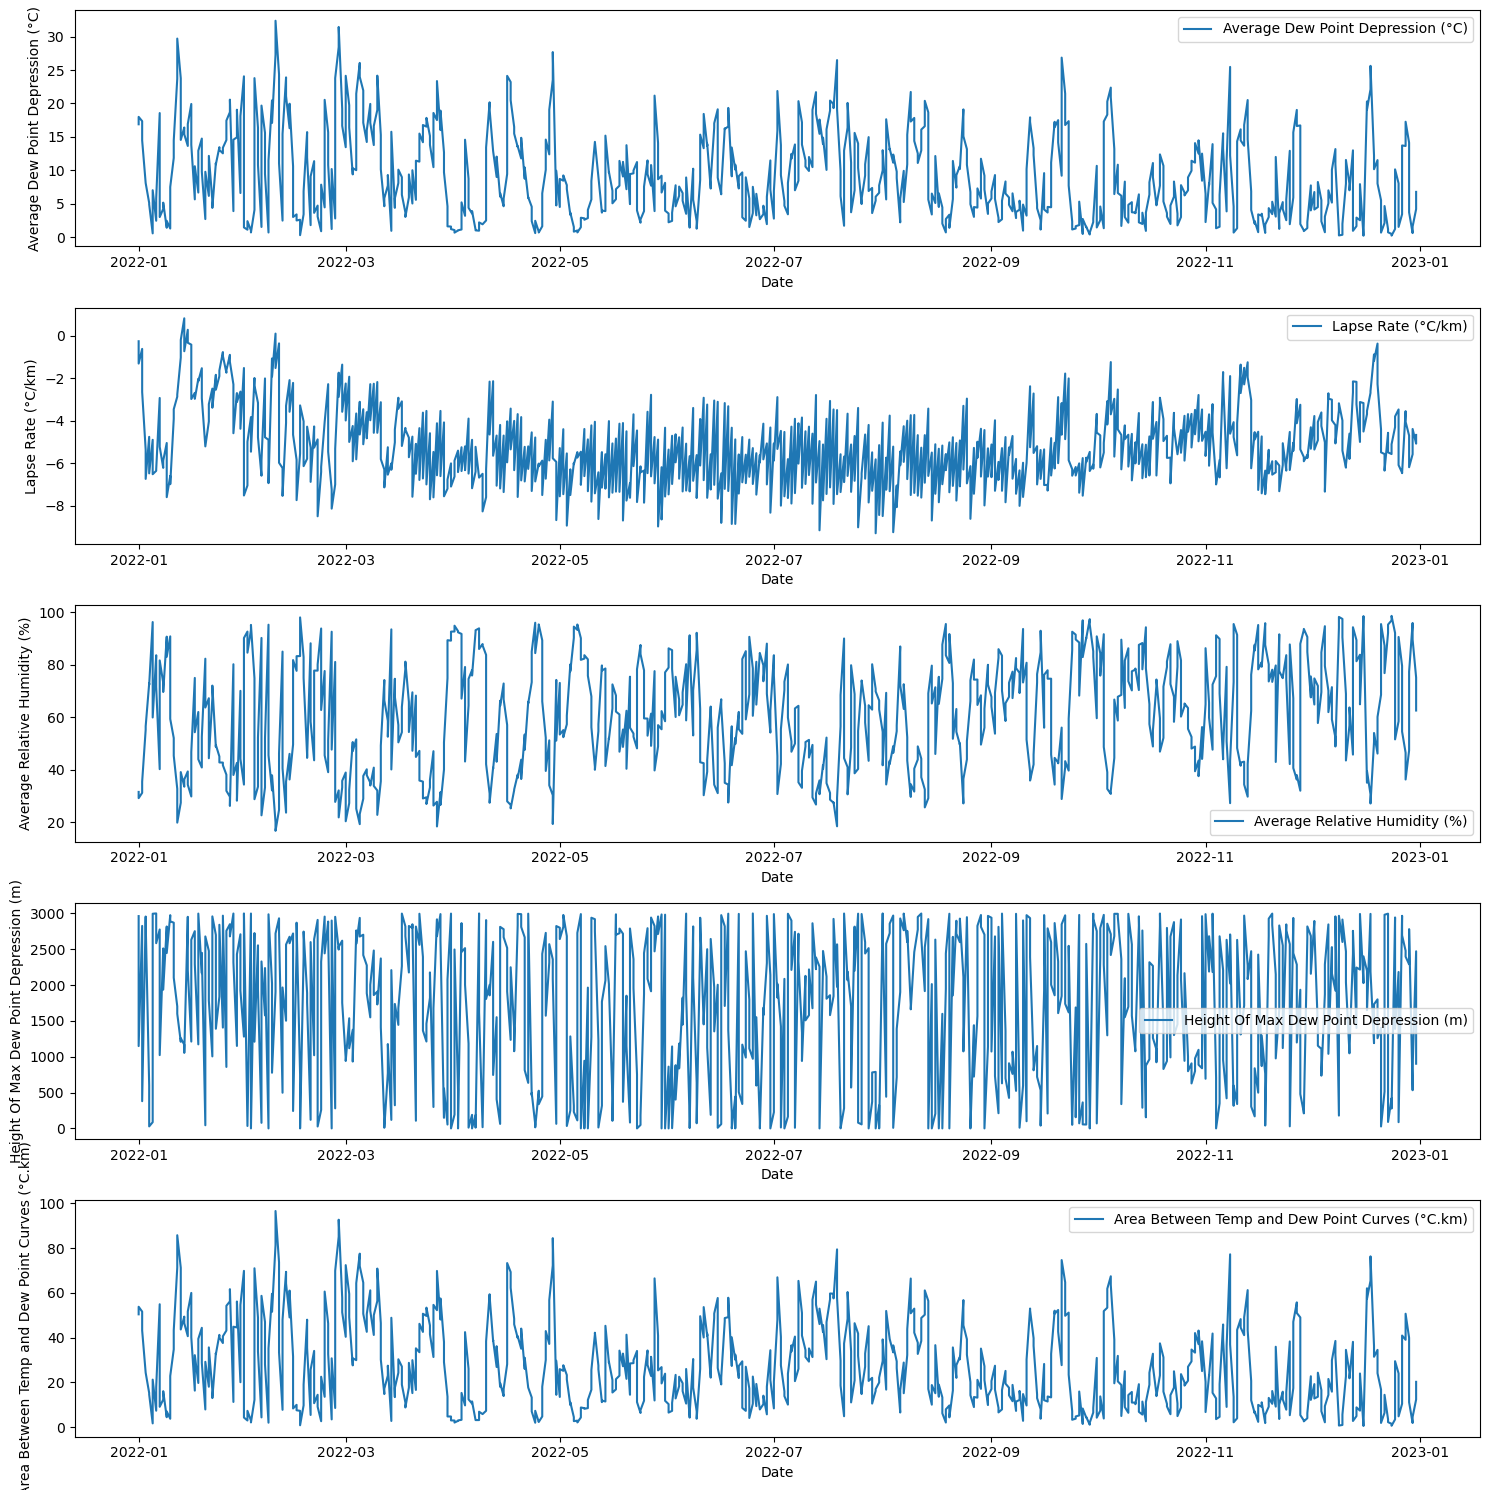

In [31]:
descriptors = ['Average Dew Point Depression (°C)', 
               'Lapse Rate (°C/km)', 
               'Average Relative Humidity (%)', 
               'Height Of Max Dew Point Depression (m)',
               'Area Between Temp and Dew Point Curves (°C.km)']

plt.figure(figsize=(15, 15))

# Create a subplot for each descriptor
for i, descriptor in enumerate(descriptors, 1):
    plt.subplot(len(descriptors), 1, i)
    plt.plot(descriptors_df_2022['Date'], descriptors_df_2022[descriptor], label=descriptor)
    plt.ylabel(descriptor)
    plt.xlabel('Date')
    plt.legend()

plt.tight_layout()
plt.show()

## Plot AQC and Precip for all events with radiosounde

In [32]:
def plot_event(event_index, save=False):
    event = events[event_index]
    plt.figure(figsize=(5,2.5))
    plt.plot(event['datetime'], event['precip'], label='precip', marker='o', markersize=5)
    plt.plot(event['datetime'], event['aqc'], label='aqc', marker='o', markersize=5)

    # Set date as title
    date = event['datetime'].iloc[0].strftime('%Y-%m-%d')
    plt.title(date)
    plt.legend()
    plt.ylabel('Precipitation (mm/h)')

    # Correct way to set major locator and formatter
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.ylim(-0.05, 1.2)
    plt.tick_params(axis='x', rotation=30)
    
    if save:
        plt.savefig(f"./figures/{date.replace('-', '_')}_event.pdf", dpi=300, bbox_inches='tight')
        
    plt.show()

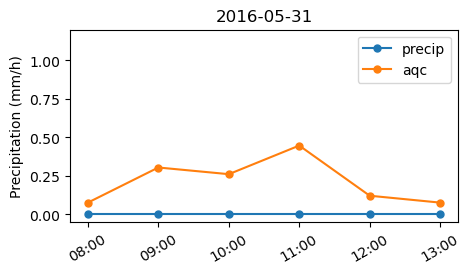

In [33]:
plot_event(1, save=True)

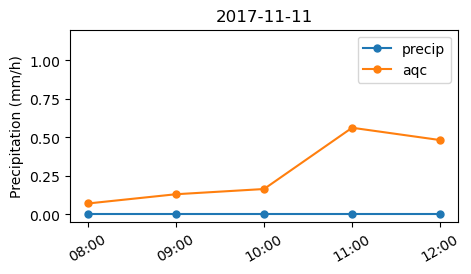

In [34]:
plot_event(4, save=True)

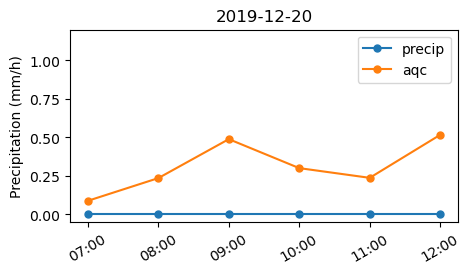

In [35]:
plot_event(13, save=True)

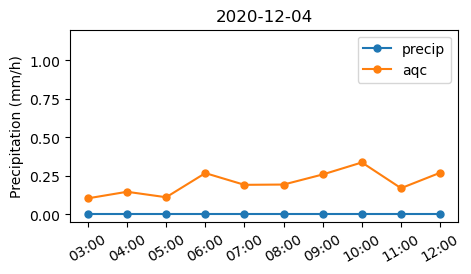

In [36]:
plot_event(15, save=True)

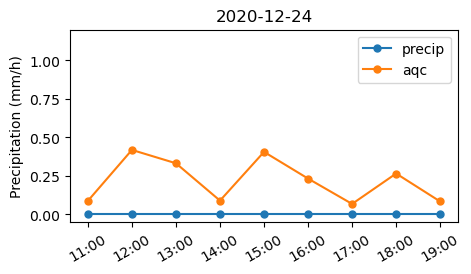

In [37]:
plot_event(16, save=True)

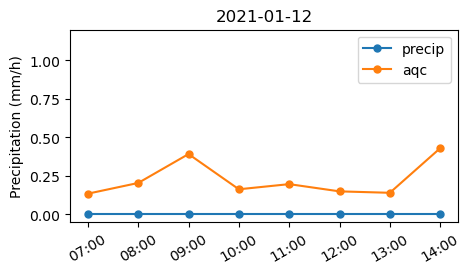

In [38]:
plot_event(17, save=True)

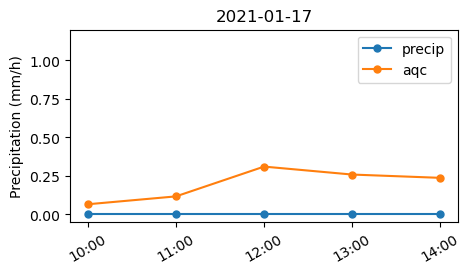

In [39]:
plot_event(18, save=True)

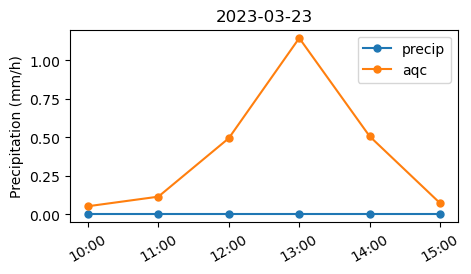

In [40]:
plot_event(25, save=True)

## Plot RH and Precip for Event 6

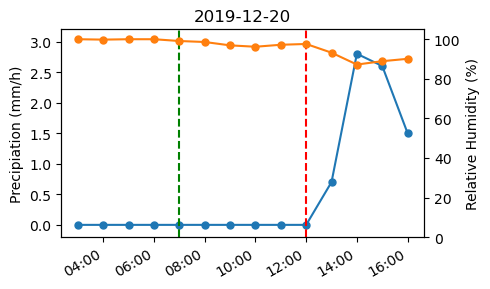

In [41]:
event_df = pre_precip_events[6] 

fig, ax_precip = plt.subplots(figsize=(5,3)) 

# Define the DateFormatter to only show the hour
hour_formatter = mdates.DateFormatter('%H:%M')

# Get the start and end of the event
start_event = event_df['datetime'].min()
end_event = event_df['datetime'].max()

# Calculate the start and end of the plot window (4 hours before and after)
start_plot = start_event - pd.Timedelta(hours=4)
end_plot = end_event + pd.Timedelta(hours=4)

# Select the precipitation and humidity data for the plot window using boolean indexing
precip_during_event = qpe[(qpe['datetime'] >= start_plot) & (qpe['datetime'] <= end_plot)]
rh_during_event = station_data[(station_data['datetime'] >= start_plot) & (station_data['datetime'] <= end_plot)]

# Plot the precipitation data
ax_precip.plot(precip_during_event['datetime'], precip_during_event['precip'], 
               marker='o', markersize=5, label='Precipitation (mm/h)')

# Create a twin y-axis for relative humidity
ax_rh = ax_precip.twinx()
ax_rh.plot(rh_during_event['datetime'], rh_during_event['rh'], 
           marker='o', markersize=5, color='#ff7f0e', label='Relative Humidity (%)')

# Highlight the event duration
ax_precip.axvline(start_event, color='green', linestyle='--')
ax_precip.axvline(end_event, color='red', linestyle='--')

# Set the title to the start date of the event
ax_precip.set_title(start_event.strftime('%Y-%m-%d'))

# Format the x-axis to only show the hour
ax_precip.xaxis.set_major_formatter(hour_formatter)

# Rotate the x-axis labels to prevent overlap
plt.setp(ax_precip.get_xticklabels(), rotation=30, ha='right')

# Set the y-axis limits
ax_rh.set_ylim(0, 105)
ax_precip.set_ylim(-0.2, 3.2)

ax_precip.set_ylabel('Precipiation (mm/h)')
ax_rh.set_ylabel('Relative Humidity (%)')

plt.tight_layout()
plt.savefig('./figures/pre_precip_event_7.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Potential Impacts on weather radar data interpretation

Here we plot AQC alongside CPC and CPC.CV for all 26 events of the Narrow Scope Analysis

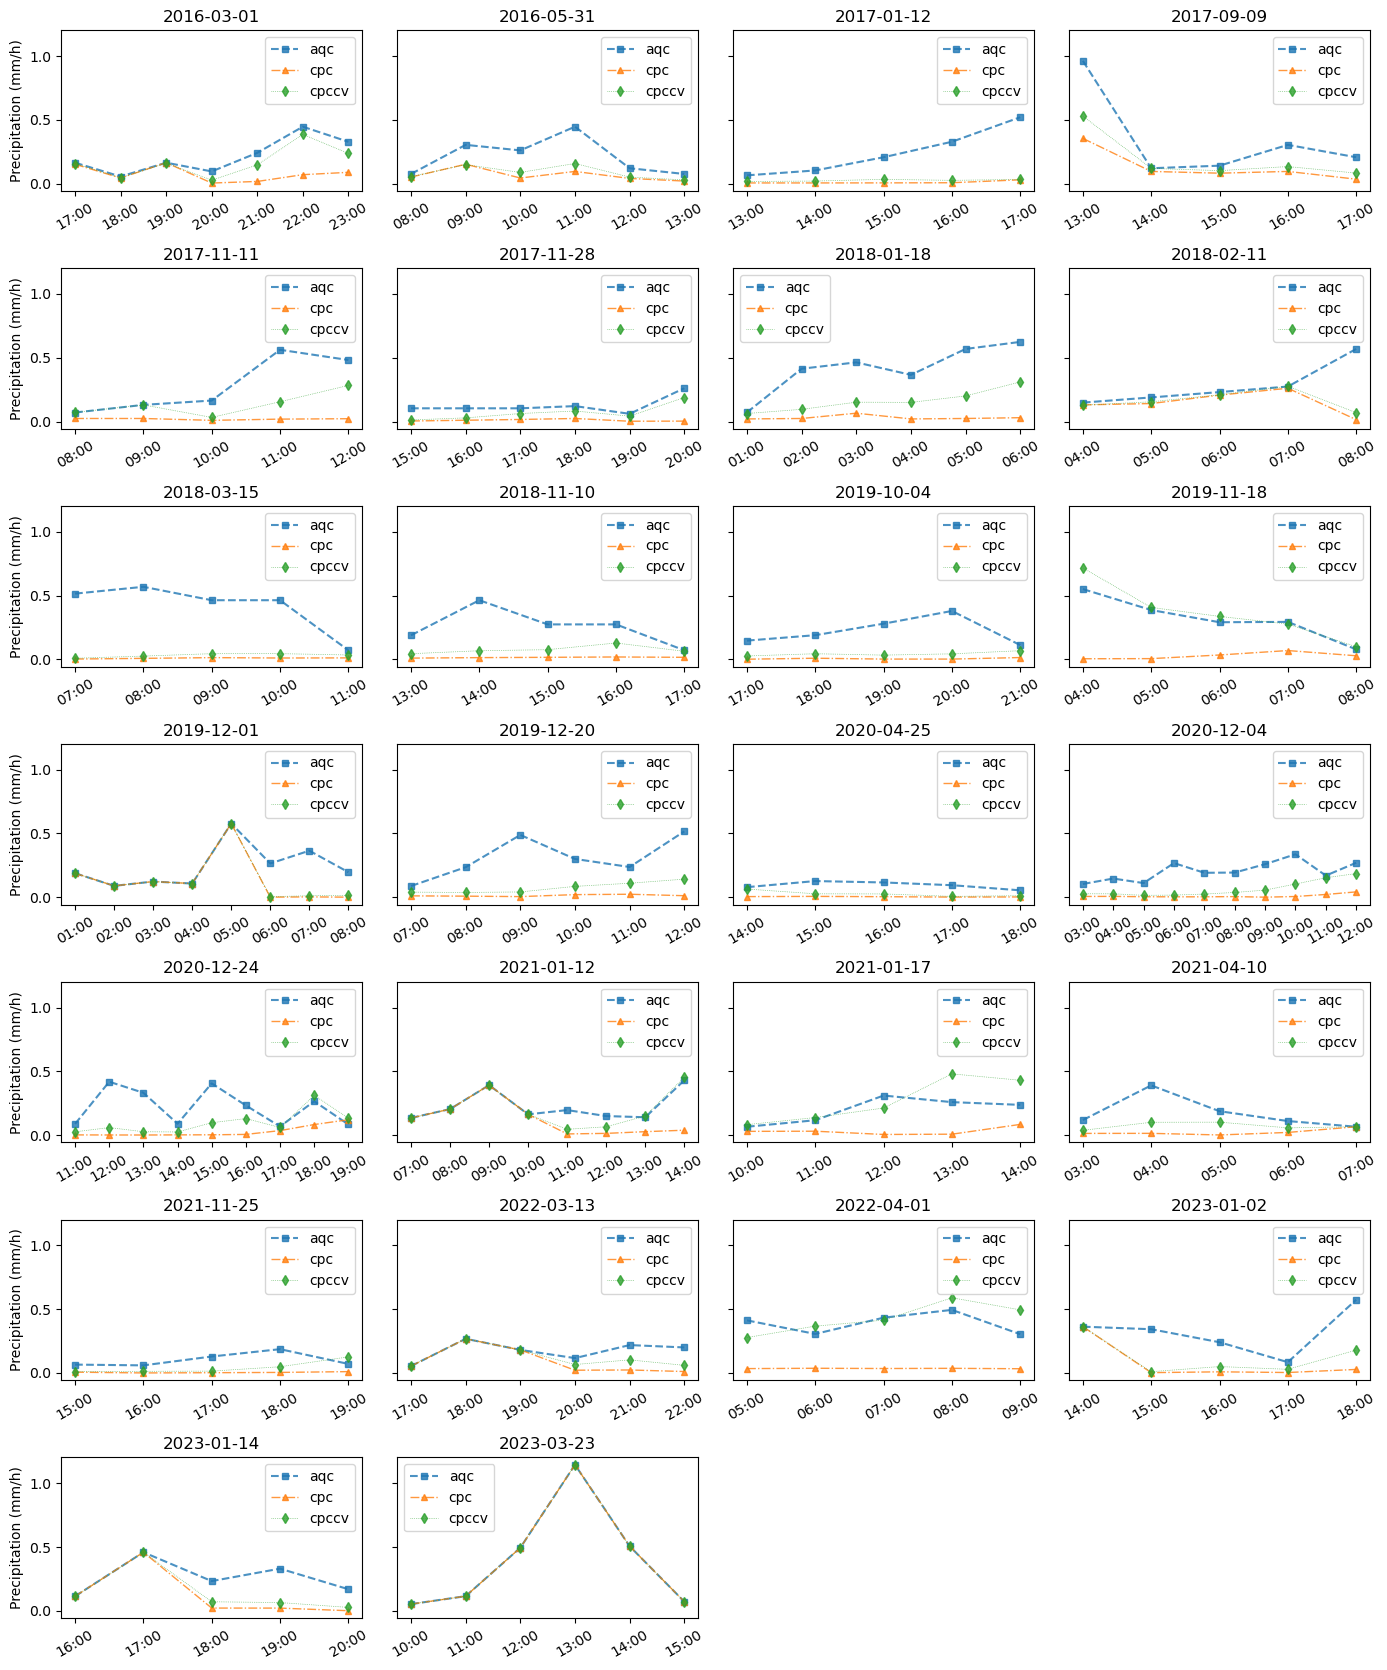

In [42]:
number_of_events = 26
rows = math.ceil(number_of_events / 4)
fig, axs = plt.subplots(rows, 4, figsize=(14, 2.4*rows), sharey=True)

# Flatten the axes array for easier iteration
axs = axs.ravel()

line_styles = ['-', '--', '-.', ':']
line_widths = [2, 1.5, 1, 0.5]
markers = ['o', 's', '^', 'd']

for i, event in enumerate(events):
    axs[i].plot(event['datetime'], event['aqc'], label='aqc', linestyle=line_styles[1], marker=markers[1], markersize=5, linewidth=line_widths[1], alpha=0.8)
    axs[i].plot(event['datetime'], event['cpc'], label='cpc', linestyle=line_styles[2], marker=markers[2], markersize=5, linewidth=line_widths[2], alpha=0.8)
    axs[i].plot(event['datetime'], event['cpccv'], label='cpccv', linestyle=line_styles[3], marker=markers[3], markersize=5, linewidth=line_widths[3], alpha=0.8)

    # Extracting the date from the index and setting it as the title
    date = event['datetime'].iloc[0].strftime('%Y-%m-%d')
    axs[i].set_title(date)
    
    axs[i].legend()
    axs[i].xaxis.set_major_locator(mdates.HourLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate x-tick labels
    axs[i].tick_params(axis='x', rotation=30)
    
    # Add y-axis label only for the subplots on the left edge
    if i % 4 == 0:  # Check if the subplot is in the first column
        axs[i].set_ylabel('Precipitation (mm/h)')

# Hide any unused subplots if the number of events is not a multiple of 6
for j in range(i+1, len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('./figures/sublimation_events_narrow_cpc.pdf', dpi=300, bbox_inches='tight')
plt.show()